# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1:</center>
### <center>  Propiedades en Venta</center>
### <center>  Grupo 18</center>


#### **Integrantes:**

* Analía Acevedo
* Santiago Daniel Marczewski Neudeck
* Lucia Belén Napoli
* Brayan Ricaldi

## <center>Notebook 1: Análisis Exploratorio y Preprocesamiento de Datos excluyendo Reduccion de la Dimensionalidad</center>

#### **Introducción**

En este trabajo práctico se propone que cada grupo de alumnos se enfrente a un problema real
de ciencia de datos, que trabaje en cada una de las etapas del proceso y que pueda resolverlo
aplicando los contenidos que vemos en la materia.

Vamos a utilizar el conjunto de datos provisto por la empresa [Properati](https://www.properati.com.ar/) correspondiente a anuncios de propiedades en venta de la República Argentina publicados durante el año 2021 .
La información fue extraída desde BigQuery (producto de Google Cloud para consultar grandes
volúmenes de datos) donde la empresa disponibiliza sus datasets con avisos de propiedades y
desarrollos inmobiliarios que están y estuvieron publicados en Properati en todo Latinoamérica
desde 2015 hasta dos meses atrás. Los datos se actualizan diariamente para mayor información
pueden consultar el siguiente [link](https://www.properati.com.ar/data/).

El objetivo principal del trabajo será aplicar técnicas de análisis exploratorio, preprocesamiento
de datos, agrupamiento, clasificación y regresión. En la sección enunciado se detallan los
objetivos particulares.

#### **Descargamos el DataSet**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sklearn.preprocessing as skp
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
from preprocessing import preprocesamiento

pd.options.display.max_columns = None

In [2]:
url = (
    "https://drive.google.com/file/d/1wScqb_M8lq3yL3ZfSZvnLyZbh4ImI7dI/view?usp=sharing"
)
url = "https://drive.google.com/uc?id=" + url.split("/")[-2]
dp_properati = pd.read_csv(url)

# dp_properati = pd.read_csv("./Datasets/properati_argentina_2021.csv")

In [3]:
df = dp_properati.copy()

Damos un primer vistazo al dataset

In [4]:
df.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay
3,QE1QVMWKAHWkd0qT0FtPWA==,2021-09-09,2022-01-27,2021-09-09,-34.900165,-54.808453,Maldonado,NaN,NaN,NaN,NaN,Venta,Casa,NaN,3.0,NaN,180.0,400000.0,USD,Casa - El Chorro
4,tJ5lSk7IysG/71OGhacNZA==,2021-09-09,2022-01-27,2021-09-09,-38.954528,-68.041862,Neuquén,NaN,NaN,NaN,NaN,Venta,PH,3.0,2.0,NaN,98.0,102000.0,USD,PH - Villa Farrell


In [5]:
df.shape

(460154, 20)

Podemos ver que tenemos al rededor de 460 mil entradas y 20 columnas:
* id: Un codigo de identificacion.
* start_date: La fecha de inicio de la publicacion.
* end_date: La fecha de finalizacion de la publicacion.
* created_on: La fecha de creacion de la publicacion.
* latitud: La latitud en la que se encuentra la propiedad.
* longitud: La longitud en la que se encuentra la propiedad.
* place_2..n: Son 5 columnas con datos sobre la ubicacion de la propiedad, como provincia, ciudad, barrio, etc.
* operation: El tipo de operacion de la publicacion, como venta, alquiler, etc.
* property_type: El tipo de propiedad, como casa, departamento, PH, etc.
* property_room: La cantidad de ambientes que posee la propiedad.
* property_bedroom: La cantidad de dormitorios que posee la propiedad.
* property_surface_total: La superficie total de la propiedad.
* property_surface_covered: La superficie cubierta de la propiedad.
* property_price: El precio de la propiedad.
* property_currency: La moneda en la que esta expresada el precio publicado.
* property_title: El titulo de la publicacion.

#### **Enunciado**
El conjunto de datos a utilizar properati_argentina_2021 se encuentra disponible en el
siguiente [enlace](https://drive.google.com/drive/folders/1BPCdW_Jab91WhMqfXcf0jYMHzjxW_XkD?usp=sharing), la descripción de las variables se encuentra disponible [aquí](https://www.properati.com.ar/data/). Para este trabajo
se plantean los siguientes objetivos generales:

* _Agrupamiento_: el objetivo será analizar si es posible agrupar los datos en función de
algún criterio, identificando a qué obedece el mismo.

* _Clasificación_: el objetivo será clasificar cada anuncio en tres categorías relacionadas al
precio de venta (alto, medio y bajo).

* _Regresión_: el objetivo será predecir el precio de venta en dólares de una propiedad tipo
vivienda ubicada en Capital Federal.

A continuación se detallan las etapas que deben ser desarrolladas en el trabajo:

### **1. Análisis Exploratorio y Preprocesamiento de Datos**
El primer paso consiste en la selección de los datos que se van a utilizar, se deben filtrar
únicamente los anuncios de propiedades de tipo vivienda ( Casa, PH y Departamento ) ubicados
en Capital Federal cuyo tipo de operación sea venta y su precio se encuentre en dólares (USD).
Se debe separar un conjunto de entrenamiento (80%) y un conjunto de test (20%).

<h4 align="center"><b> Filtro por el enunciado </b></h4>

In [6]:
# Vamos a eliminar las filas que tengan precio en pesos o NaN
idx_prices = df[df.property_currency.apply(lambda curr: curr != "USD")].index
df.drop(idx_prices, inplace=True)
# Tambien eliminamos las propiedades que no se encuentren en Capital Federal
idx_location = df[df.place_l2.apply(lambda loc: loc != "Capital Federal")].index
df.drop(idx_location, inplace=True)
# Eliminamos las que no sean operaciones de tipo venta
idx_op = df[df.operation.apply(lambda op: op != "Venta")].index
df.drop(idx_op, inplace=True)
# Por ultimo eliminamos las que no sean de tipo vivienda
type_vivienda = ["Departamento", "PH", "Casa"]
idx_type = df[df.property_type.apply(lambda t: t not in type_vivienda)].index
df.drop(idx_type, inplace=True)
# Y reseteamos indices
df.reset_index(drop=True, inplace=True)

df.shape

(94249, 20)

Vemos si hay datos raros en el dataset properati

In [7]:
con_caracter_raro = df.astype("str").eq("-").any(0)
con_caracter_raro

id                          False
start_date                  False
end_date                    False
created_on                  False
latitud                     False
longitud                    False
place_l2                    False
place_l3                    False
place_l4                    False
place_l5                    False
place_l6                    False
operation                   False
property_type               False
property_rooms              False
property_bedrooms           False
property_surface_total      False
property_surface_covered    False
property_price              False
property_currency           False
property_title              False
dtype: bool

Vemos si hay filas duplicadas

In [8]:
# Armamos lista de las columnas excluyendo las que podrian dar problemas a la hora de identificar duplicados
columns = df.columns.tolist()[4:]
# Y buscamos duplicados
df[df.duplicated(subset=columns[:-1])].head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
49,FblpEe26U1lQkU5vRzAtmg==,2021-09-09,2021-09-09,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,NaN,NaN,Venta,Departamento,NaN,4.0,400.0,NaN,2700000.0,USD,Departamento - Palermo Chico
186,5fV18BNo0KALCwNBrnNwlw==,2021-09-09,2022-01-27,2021-09-09,-34.604660,-58.395385,Capital Federal,Barrio Norte,NaN,NaN,NaN,Venta,Departamento,1.0,1.0,42.0,38.0,85000.0,USD,Ayacucho 400 Monoambiente A ESTRENAR!
187,LIeYF5ewYWkjtBZb8xKt3g==,2021-09-09,2022-01-27,2021-09-09,-34.604660,-58.395385,Capital Federal,Barrio Norte,NaN,NaN,NaN,Venta,Departamento,1.0,1.0,42.0,38.0,85000.0,USD,Ayacucho 400 Monoambiente A ESTRENAR!
188,ZB4UnAasDWbvahAXoG6m3A==,2021-09-09,2022-01-27,2021-09-09,-34.604660,-58.395385,Capital Federal,Barrio Norte,NaN,NaN,NaN,Venta,Departamento,1.0,1.0,42.0,38.0,85000.0,USD,Ayacucho 400 Monoambiente A ESTRENAR!
243,53k8bQTyzBZ5vCcAjKIo6g==,2021-09-09,2022-02-09,2021-09-09,-34.580818,-58.491051,Capital Federal,Villa Urquiza,NaN,NaN,NaN,Venta,Departamento,2.0,1.0,100.0,87.0,189645.0,USD,POZO 3 AMBIENTES COCHERA OPCIONAL - VILLA URQUIZA


Las borramos y vemos cuantas son:

In [9]:
size_antes = len(df)
# Finalmente borramos los duplicados
df = df.drop_duplicates(subset=columns[:-1])
# Y reseteamos indices
df.reset_index(drop=True, inplace=True)
size_despues = len(df)
print(f"Se eliminaron: {size_antes-size_despues} filas duplicadas")

Se eliminaron: 13236 filas duplicadas


Vemos la suma de datos nulos por columna

In [10]:
print(df.isna().sum())

id                              0
start_date                      0
end_date                        0
created_on                      0
latitud                      3136
longitud                     3136
place_l2                        0
place_l3                      395
place_l4                    78114
place_l5                    81013
place_l6                    81013
operation                       0
property_type                   0
property_rooms                958
property_bedrooms            9596
property_surface_total       4206
property_surface_covered     2828
property_price                  0
property_currency               0
property_title                  0
dtype: int64


Y tambien que porcentaje representan del total

In [11]:
filas_totales = df.shape[0]
print(df.isna().sum() / filas_totales * 100)

id                            0.000000
start_date                    0.000000
end_date                      0.000000
created_on                    0.000000
latitud                       3.870984
longitud                      3.870984
place_l2                      0.000000
place_l3                      0.487576
place_l4                     96.421562
place_l5                    100.000000
place_l6                    100.000000
operation                     0.000000
property_type                 0.000000
property_rooms                1.182526
property_bedrooms            11.845013
property_surface_total        5.191759
property_surface_covered      3.490798
property_price                0.000000
property_currency             0.000000
property_title                0.000000
dtype: float64


Se observa que hay un gran porcentaje de datos nulos en el feature place_l4. Ademas podemos ver que las features place_l5 y place_l6 tienen el 100% de sus filas nulas.

Solo nos quedamos con las longitudes y latitudes que pertenezca aproximadamente a Capital Federal

In [12]:
# Guardamos el tamano del dataset
size_antes = len(df)
# Primero nos quedamos solamente con las filas con longitudes validas
df = df[
    ((-58.5314375 < df["longitud"]) & (df["longitud"] < -58.3415625))
    | (df["longitud"].isna())
]
# Y luego repetimos el proceso para las latitudes
df = df[
    ((-34.7045625 < df["latitud"]) & (df["latitud"] < -34.5270625))
    | (df["latitud"].isna())
]
# Buscamos el tamano del dataset despues de sacar coordenadas invalidas
size_despues = len(df)
# Y reseteamos indices
df.reset_index(drop=True, inplace=True)
print(
    f"Se eliminaron: {size_antes-size_despues} filas con coordenadas invalidas, lo cual representa un {round((size_antes-size_despues) / size_antes * 100, 3)}%"
)

Se eliminaron: 190 filas con coordenadas invalidas, lo cual representa un 0.235%


In [13]:
tam_inicial = df.shape[0]
print(
    f"El tamano inicial del dataset luego de tomar solamente los datos requeridos es de: {tam_inicial} filas"
)

El tamano inicial del dataset luego de tomar solamente los datos requeridos es de: 80823 filas


#### **a) Exploración Inicial:** 
Analizar cada variable, considerando los siguientes aspectos
* Tipo de variable
* Variables Cuantitativas: calcular medidas de resumen: media, mediana, q1,
q3, moda.
* Variables Cualitativas mostrar cantidad de valores posibles, y frecuencias de cada
uno.
* Determinar variables irrelevantes en el análisis (Ids por ejemplo)
* Realizar un análisis gráfico de las distribuciones de las variables
* Analizar las correlaciones existentes entre las variables.

A partir de este análisis generar conclusiones sobre los datos.



<h4 align="center"><b> Tipo de variable </b></h4>

In [14]:
df.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80823 entries, 0 to 80822
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        80823 non-null  object 
 1   start_date                80823 non-null  object 
 2   end_date                  80823 non-null  object 
 3   created_on                80823 non-null  object 
 4   latitud                   77687 non-null  float64
 5   longitud                  77687 non-null  float64
 6   place_l2                  80823 non-null  object 
 7   place_l3                  80618 non-null  object 
 8   place_l4                  2899 non-null   object 
 9   place_l5                  0 non-null      object 
 10  place_l6                  0 non-null      float64
 11  operation                 80823 non-null  object 
 12  property_type             80823 non-null  object 
 13  property_rooms            79917 non-null  float64
 14  proper

Se observa que hay 12 variables string, 8 float

<h4 align="center"><b> Variables Cuantitativas - calcular medidas de resumen: media, mediana, q1
q3, moda. </b></h4>

<h4 align="center"><b> Realizar un análisis gráfico de las distribuciones de las variables </b></h4>

Veamos un resumen general estadistico de las variables cuantitativas:

In [15]:
medidas_resumen = df.describe()
medidas_resumen

,latitud,longitud,place_l6,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
count,77687.000000,77687.000000,0.0,79917.000000,71239.00000,76639.000000,77995.000000,8.082300e+04
mean,-34.596741,-58.439070,NaN,2.814670,2.01116,105.976318,87.909802,2.143545e+05
std,0.026524,0.038171,NaN,1.414939,1.13695,990.250355,1069.151461,2.855791e+05
min,-34.698989,-58.530391,NaN,1.000000,-1.00000,10.000000,1.000000,5.000000e+03
25%,-34.616636,-58.466707,NaN,2.000000,1.00000,45.000000,40.000000,9.500000e+04
50%,-34.596323,-58.439267,NaN,3.000000,2.00000,65.000000,57.000000,1.400000e+05
75%,-34.577847,-58.409025,NaN,4.000000,3.00000,102.000000,87.000000,2.300000e+05
max,-34.535964,-58.343239,NaN,40.000000,70.00000,137000.000000,217000.000000,2.140000e+07


##### Observemos cada feature en mas detalle:

In [16]:
"""
Precondicion: 
        - f debe ser un feature numerico de df y contener al menos una fila valida.
"""


def imprimir_resumen(df, f):
    media = round(df[f].mean(), 1)
    mediana = df[f].median()
    cuantiles = df[f].quantile(q=[0.25, 0.75])
    moda = df[f].mode()
    q1 = round(cuantiles.iloc[0], 1)
    q3 = round(cuantiles.iloc[1], 1)
    return pd.DataFrame(
        {"media": media, "mediana": mediana, "q1": q1, "q3": q3, "moda": moda[0]},
        index=[f],
    )

##### Fecha de publicacion (dia y mes):

Vamos a parsear la fecha de creacion de la publicacion, creando dos nuevas features antes de borrar la original:

In [17]:
"""
Precondicion: 
        - f debe ser un feature de df.
        - Los datos de f son del formato yy-mm-dd
        - yy/mm/dd son int en formato string
"""


def procesar_fechas(df, f):
    day = []
    month = []
    year = []
    for date in df[f]:
        _year, _month, _day = date.split("-")
        day.append(int(_day))
        month.append(int(_month))
        year.append(int(_year))
    return day, month, year

Descartamos el año porque al ser un dataset unicamente del año 2021 es un valor redundante:

In [18]:
created_on_day, created_on_month, created_on_year = procesar_fechas(df, "created_on")
df["dia"] = created_on_day
df["mes"] = created_on_month

Text(0.5, 1.0, 'Distribucion de mes de publicacion')

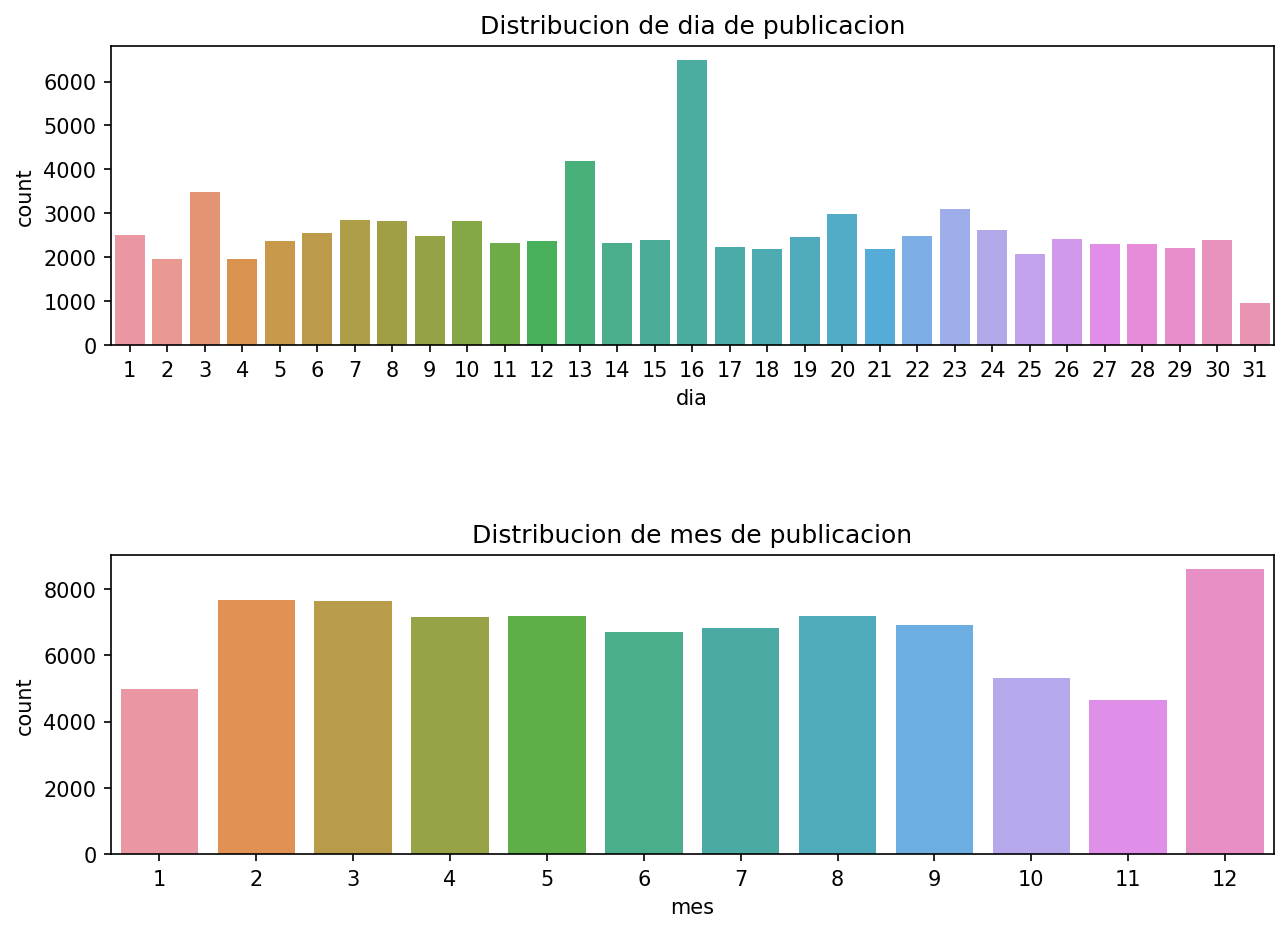

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=150, figsize=(10, 7))
sns.countplot(
    x="dia",
    data=df,
    ax=axes[0],
)
sns.countplot(
    x="mes",
    data=df,
    ax=axes[1],
)
plt.subplots_adjust(hspace=0.7)
axes[0].set_title("Distribucion de dia de publicacion")
axes[1].set_title("Distribucion de mes de publicacion")

Podemos observar que el mes mas popular para publicar una propiedad a la venta es Diciembre, mientras que el dia mas elegido es el 16.

##### Longitud y Latitud:

In [20]:
# Medidas de resumen para la variable longitud
imprimir_resumen(df, "longitud")

,media,mediana,q1,q3,moda
longitud,-58.4,-58.439267,-58.5,-58.4,-58.424956


In [21]:
# Medidas de resumen para la variable latitud
imprimir_resumen(df, "latitud")

,media,mediana,q1,q3,moda
latitud,-34.6,-34.596323,-34.6,-34.6,-34.604538


Text(0.5, 1.0, 'Latitud')

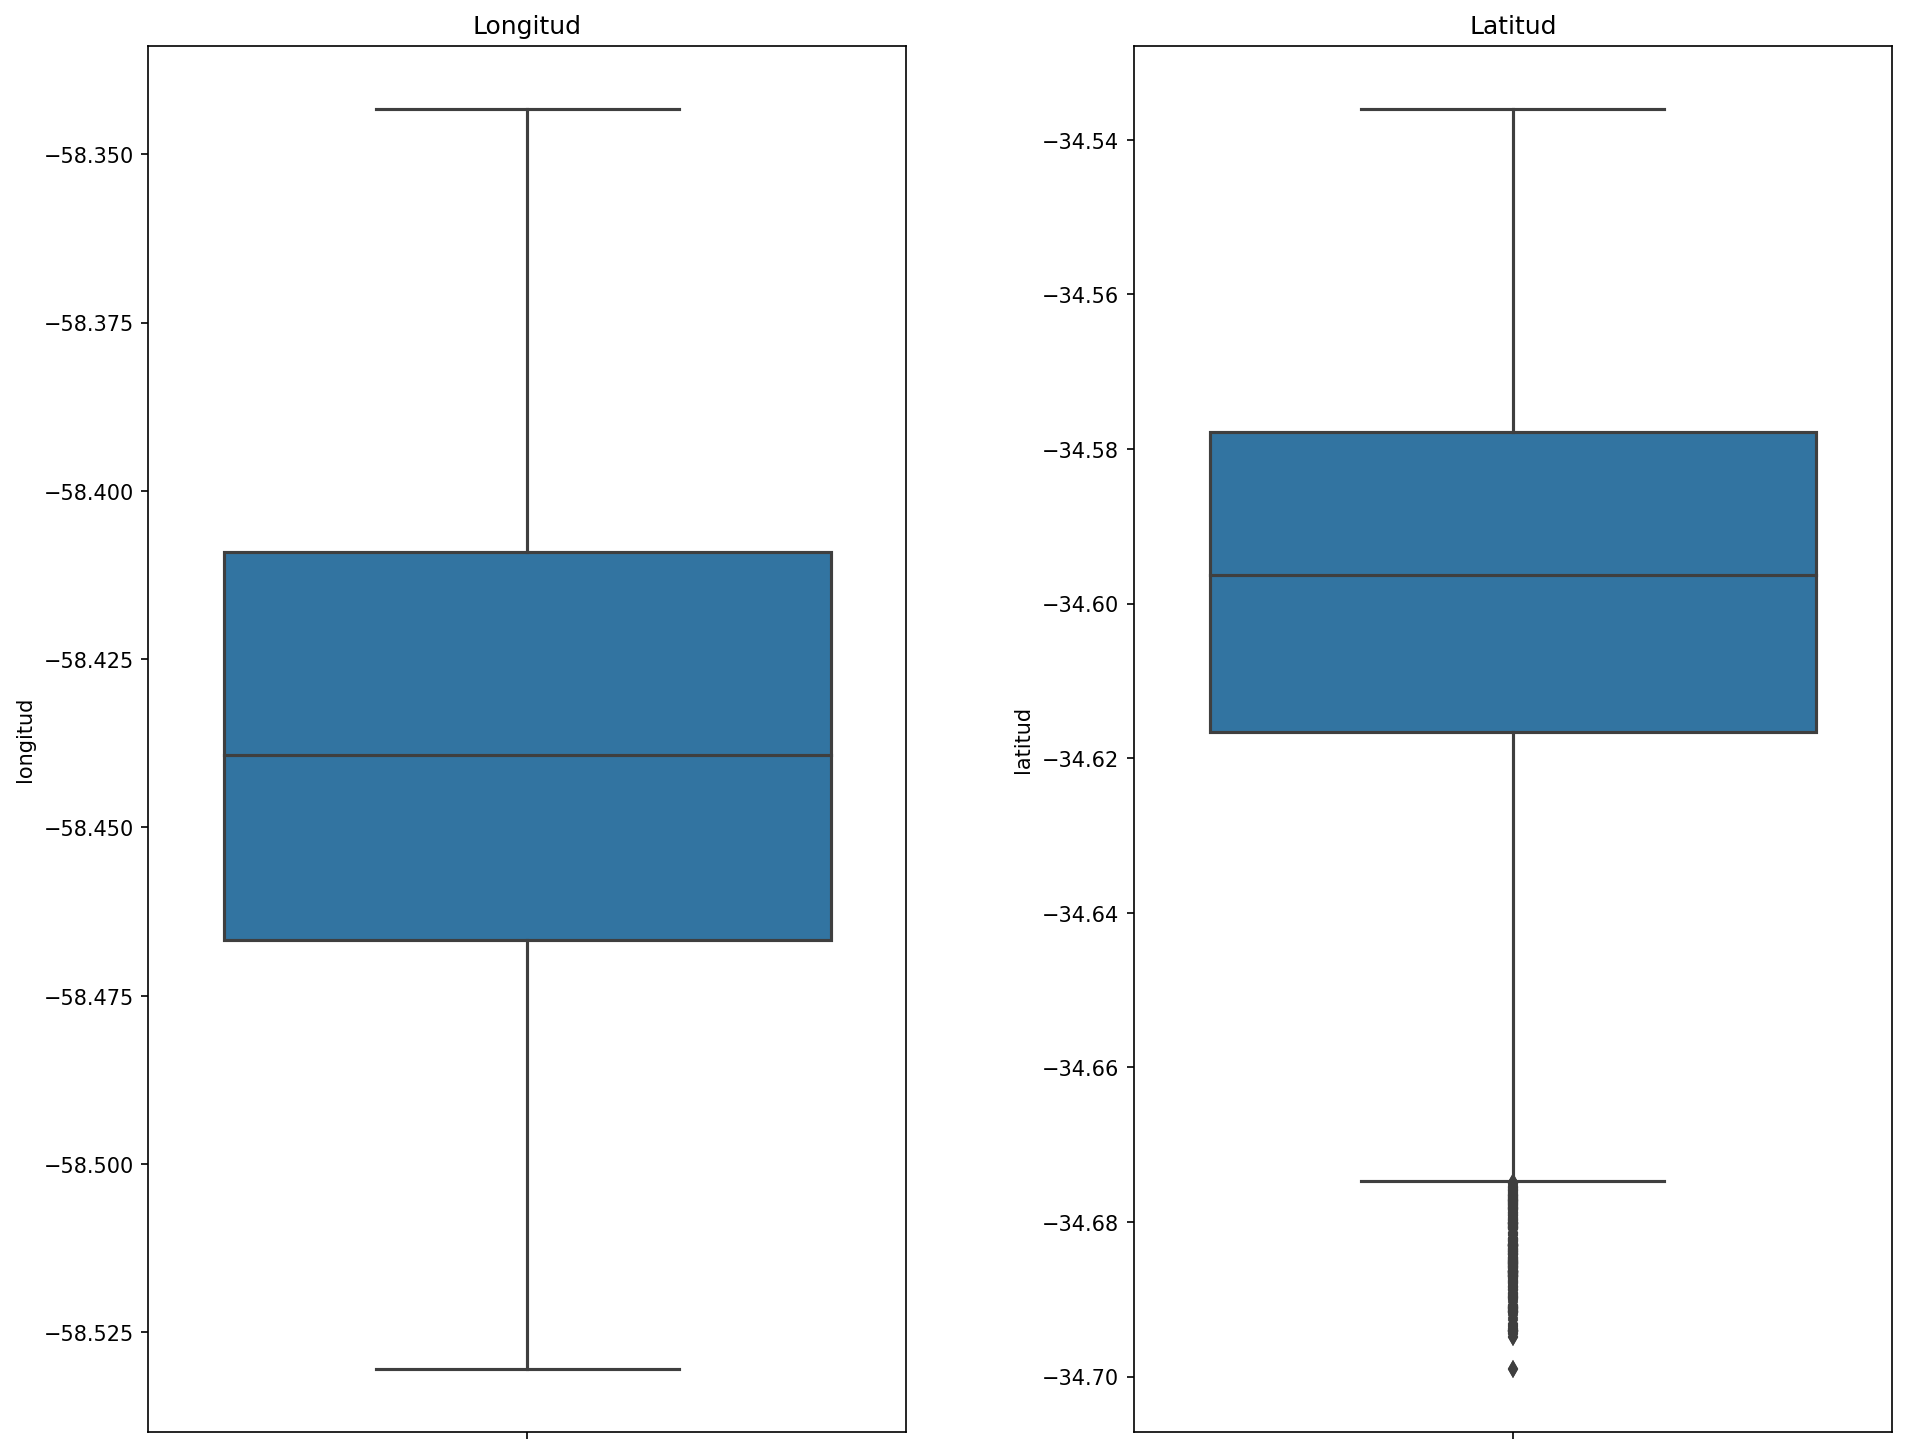

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(15, 12))
sns.boxplot(y=df["longitud"], ax=axes[0])
sns.boxplot(y=df["latitud"], ax=axes[1])
plt.subplots_adjust(wspace=0.3)
axes[0].set_title("Longitud")
axes[1].set_title("Latitud")

##### Precio (property_price):

In [23]:
# Medidas de resumen para la variable property_price
imprimir_resumen(df, "property_price")

,media,mediana,q1,q3,moda
property_price,214354.5,140000.0,95000.0,230000.0,110000.0


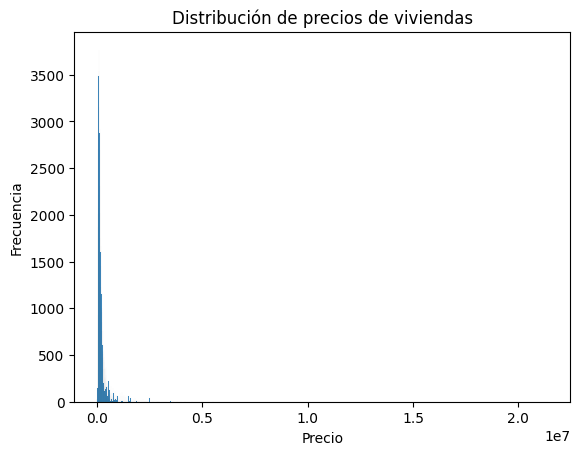

In [24]:
# Histograma de los precios
# sns.set(rc={"figure.figsize":(10, 45)})
sns_hist = sns.histplot(data=df["property_price"], alpha=0.85).set(
    title="Distribución de precios de viviendas", xlabel="Precio", ylabel="Frecuencia"
)

##### Ambientes (property_rooms):

In [25]:
# Medidas de resumen para la variable property_rooms
imprimir_resumen(df, "property_rooms")

,media,mediana,q1,q3,moda
property_rooms,2.8,3.0,2.0,4.0,3.0


In [26]:
# Vemos cuantos valores unicos hay en la columna, el dato es interesante ya que el rango de valores deberia ser bastante acotado
print(f"El feature Ambientes tiene: {len(df.property_rooms.unique())} valores unicos")

El feature Ambientes tiene: 28 valores unicos


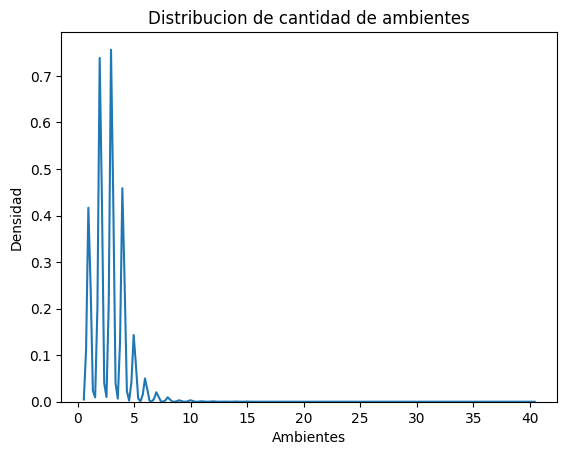

In [27]:
# Distribucion de la variable property_rooms
sns_hist = sns.kdeplot(data=df.property_rooms).set(
    title="Distribucion de cantidad de ambientes", xlabel="Ambientes", ylabel="Densidad"
)

##### Dormitorios (property_bedrooms)

In [28]:
# Medidas de resumen para la variable property_bedrooms
imprimir_resumen(df, "property_bedrooms")

,media,mediana,q1,q3,moda
property_bedrooms,2.0,2.0,1.0,3.0,1.0


In [29]:
# Vemos cuantos valores unicos hay en la columna, el dato es interesante ya que el rango de valores deberia ser bastante acotado
print(
    f"El feature Dormitorios tiene: {len(df.property_bedrooms.unique())} valores unicos"
)

El feature Dormitorios tiene: 25 valores unicos


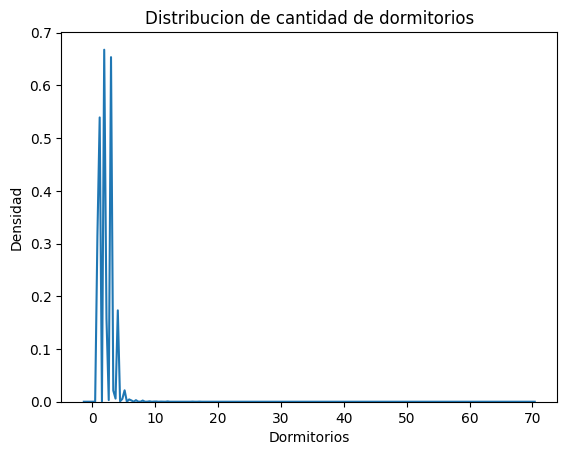

In [30]:
# Distribucion de la variable property_bedrooms
sns_hist = sns.kdeplot(data=df.property_bedrooms).set(
    title="Distribucion de cantidad de dormitorios",
    xlabel="Dormitorios",
    ylabel="Densidad",
)

##### Superficie total (property_surface_total)

In [31]:
# Medidas de resumen para la variable property_surface_total
imprimir_resumen(df, "property_surface_total")

,media,mediana,q1,q3,moda
property_surface_total,106.0,65.0,45.0,102.0,50.0


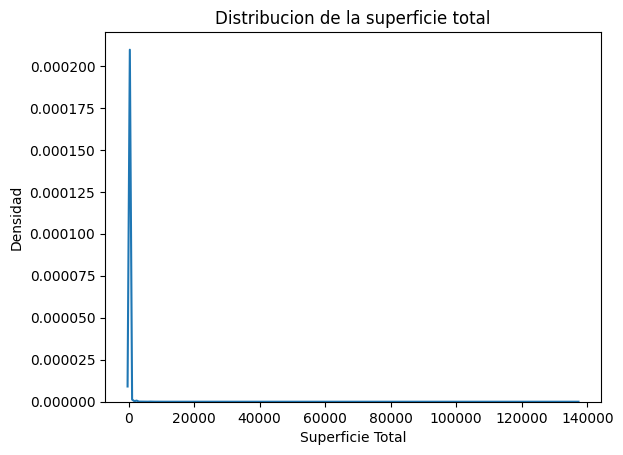

In [32]:
# Distribucion de la variable property_surface_total
sns_hist = sns.kdeplot(data=df.property_surface_total).set(
    title="Distribucion de la superficie total",
    xlabel="Superficie Total",
    ylabel="Densidad",
)

##### Superficie cubierta (property_surface_covered)

In [33]:
# Medidas de resumen para la variable property_surface_covered
imprimir_resumen(df, "property_surface_covered")

,media,mediana,q1,q3,moda
property_surface_covered,87.9,57.0,40.0,87.0,40.0


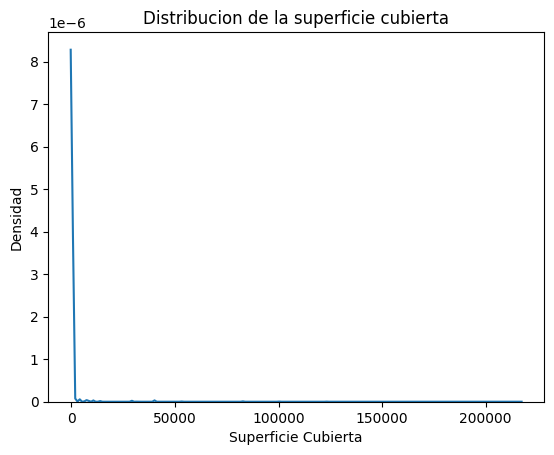

In [34]:
# Distribucion de la variable property_surface_covered
sns_hist = sns.kdeplot(data=df.property_surface_covered).set(
    title="Distribucion de la superficie cubierta",
    xlabel="Superficie Cubierta",
    ylabel="Densidad",
)

<h4 align="center"><b> Variables Cualitativas - mostrar cantidad de valores posibles, y frecuencias de cada
uno </b></h4>

##### Tipo (property_type)

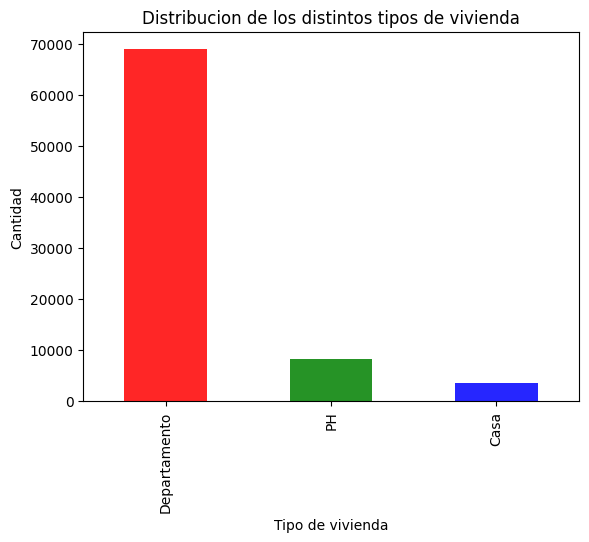

In [35]:
# Gráfico de barras
grf_ds = (
    df["property_type"]
    .value_counts()
    .plot.bar(
        alpha=0.85,
        title="Distribucion de los distintos tipos de vivienda",
        xlabel="Tipo de vivienda",
        ylabel="Cantidad",
        color=["r", "g", "b"],
    )
)

Podemos ver que el tipo mas frecuente de propiedad es Departamento.

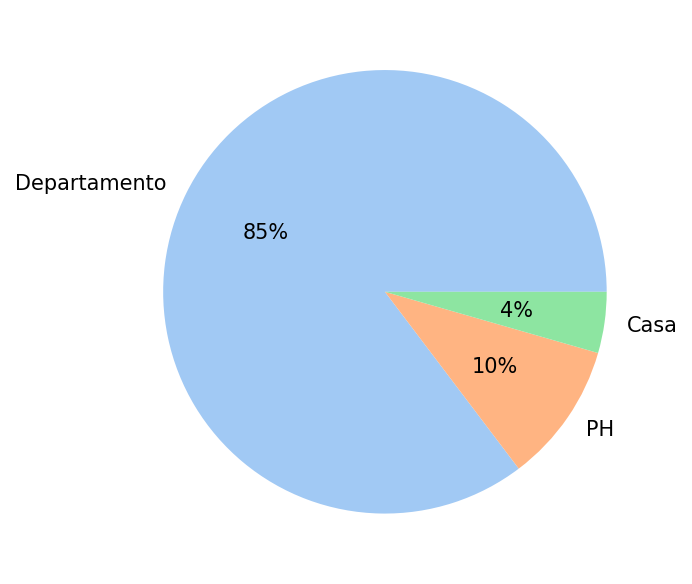

In [36]:
# Grafico de torta
plt.figure(dpi=150)
data = df["property_type"].value_counts()
labels = df["property_type"].value_counts().index
colors = sns.color_palette("pastel")

plt.pie(data, labels=labels, colors=colors, autopct="%.0f%%")
plt.show()

Especificamente el 86% de los datos corresponde a una publicacion de departamento.

##### Barrios (place_l3)

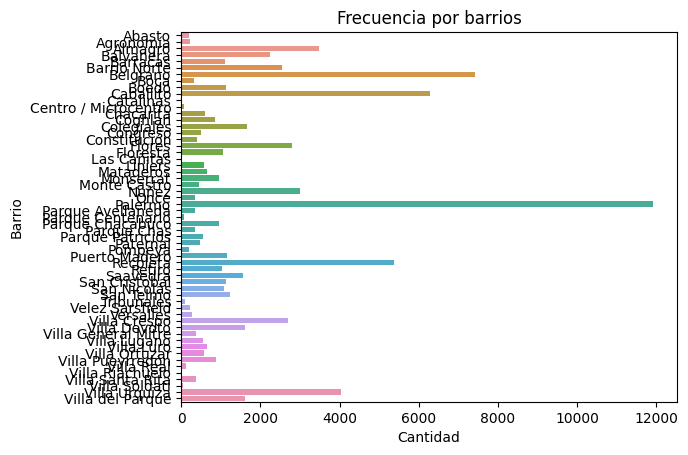

In [37]:
# Seaborn
ds_agrupado_Pclass = df.groupby(
    ["place_l3"]
).count()  # Calculo la frecuencia de cada barrio

eje_y = ds_agrupado_Pclass.index.tolist()
eje_x = ds_agrupado_Pclass["property_price"].tolist()
# sns.set(rc={"figure.figsize":(15, 45)})
sns_bar_plot = sns.barplot(x=eje_x, y=eje_y, data=ds_agrupado_Pclass, orient="h").set(
    title="Frecuencia por barrios", xlabel="Cantidad", ylabel="Barrio"
)

##### Título del anuncio (property_title)

Si bien la informacion que podamos obtener del titulo de la publicacion es limitada al ser un campo que puede cambiar mucho y depende exclusivamente de la persona que la escribe, vamos a analizarla de todas maneras para intentar encontrar algo que pueda servirnos.

In [38]:
df["property_title"].value_counts().head(60)

Departamento - Palermo                             1155
Departamento - Recoleta                            1142
Departamento - Belgrano                             995
Departamento - Caballito                            822
Departamento - Almagro                              551
Departamento - Barrio Norte                         550
Departamento - Villa Urquiza                        548
Departamento - Villa Crespo                         428
Departamento - Flores                               402
Departamento - Nuñez                                397
Departamento venta                                  334
Departamento - Balvanera                            321
Departamento - Puerto Madero                        299
Departamento - Palermo Hollywood                    296
Departamento - San Telmo                            274
Departamento - Las Cañitas                          259
Departamento - Colegiales                           243
Departamento - Saavedra                         

Entre los formatos mas populares se encuentra: TIPO - BARRIO.

In [39]:
df["property_title"].value_counts().tail(10)

Nuevo Ingreso Chateau Puerto Madero                                                                     1
Venta dpto 4 amb con baulera en San Cristobal                                                           1
Departamento · 3 Ambientes c/ Cochera· Pasco 1000 · San Cristobal                                       1
Venta Dto 3 amb c/patio Excelente Estado V Urquiza                                                      1
Oportunidad monoambiente  a metros del subte B                                                          1
MUY BUEN SEMIPISO AL CONTRAFRENTE CON BALCÓN, VISTA ABIERTA.-                                           1
Venta Departamento 3 ambientes con dependencia, balcón y lavadero Villa Urquiza                         1
Hermoso y luminoso 3 ambientes con balcón en el barrio de Villa Urquiza!                                1
Duplex 3 Ambientes - Jardines De Roosevelt - V. Urquiza                                                 1
VENTA MONOAMBIENTE APAISADO y DIVISIBLE AL CF 

Y naturalmente entre los formatos menos frecuentes encontramos convenciones muy variadas.

In [40]:
df_title = df.groupby("property_title").filter(lambda x: len(x) > 200)

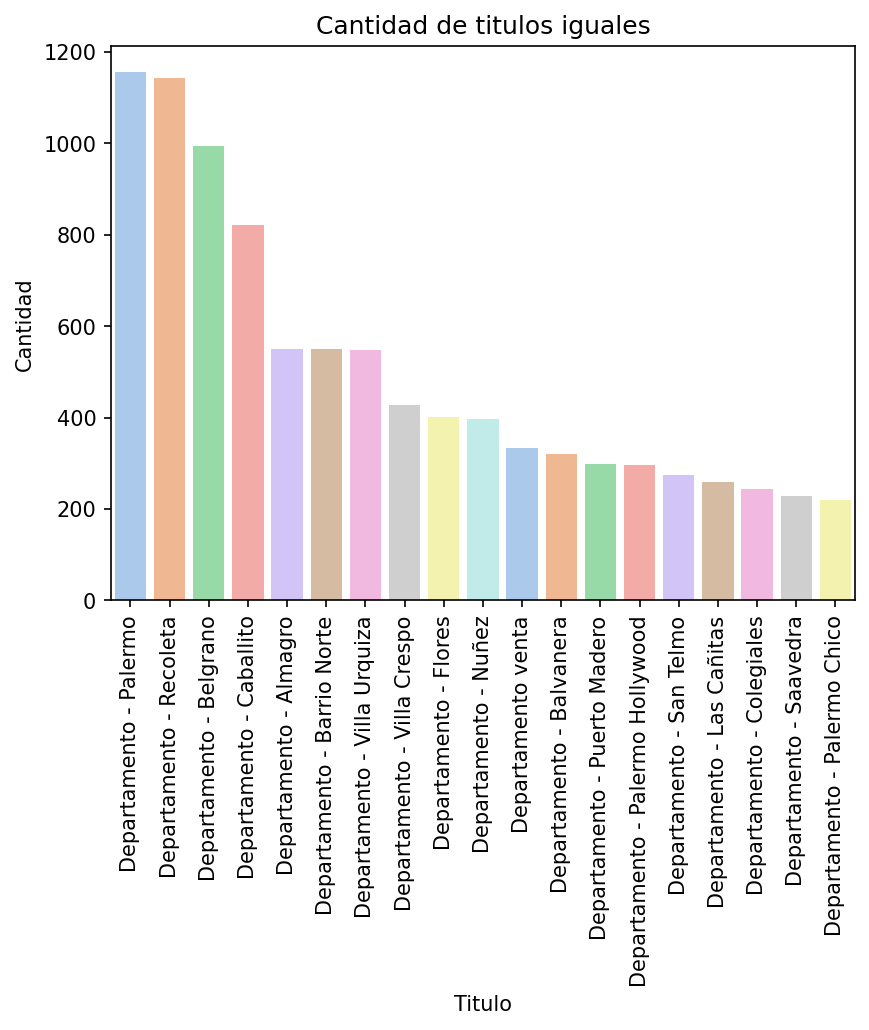

In [41]:
plt.figure(dpi=150)
colors = sns.color_palette("pastel")
sns.countplot(
    x="property_title",
    data=df_title,
    palette=colors,
    order=df_title.property_title.value_counts().index,
)
plt.ylabel("Cantidad")
plt.xlabel("Titulo")
plt.xticks(rotation=90)
plt.title("Cantidad de titulos iguales")
plt.show()

In [42]:
df_t = df["property_title"].str.split("-", expand=True)
df_t.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,VENTA CASA LLAVE EN MANO,COSTA ESMERALDA,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,VENTA TRES AMBIENTES LA BOCA PISO ALTO,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,Departamento,4 Ambientes,Catalinas Sur,None,None,None,None,None,None,None,None,None,None,None,None,None
3,Venta departamento 4 ambientes Once,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,PH,Boedo,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [43]:
df_t = df_t[[0, 1]]
df_t.columns = ["Tipo", "Barrio"]
df_t

,Tipo,Barrio
0,VENTA CASA LLAVE EN MANO,COSTA ESMERALDA
1,VENTA TRES AMBIENTES LA BOCA PISO ALTO,None
2,Departamento,4 Ambientes
3,Venta departamento 4 ambientes Once,None
4,PH,Boedo
...,...,...
80818,Espectacular 4 amb130m2 con Balcon Terraza!!!,None
80819,3 ambientes con cochera listo para habitar!,None
80820,VENTA MONOAMBIENTE CON PATIO SOL DE MAÑANA ///...,None
80821,VENTA MONOAMBIENTE APAISADO y DIVISIBLE AL CF ...,None


In [44]:
df_t = df_t.loc[
    (df_t["Tipo"] == "Casa") | (df_t["Tipo"] == "PH") | (df_t["Tipo"] == "Departamento")
]
df_t.head(10)

,Tipo,Barrio
1649,PH,Triplex tipo casa con cochera y jardin!
3740,Casa,Saavedra
3758,Casa,venta
5147,PH,"Entorno Parque Saavedra, Av Cramer y Av Balbin"
6823,PH,Venta
6874,PH,MONO
9096,Departamento,Belgrano 2Ambientes P.B. a mts Subte Apto prof...
10018,PH,4 AMBIENTES
10781,Departamento,None
12605,PH,CASA


#### <h4 align="center"><b> Determinar variables irrelevantes en el análisis </b></h4>

Se eliminaran los siguientes features:
*  Id: Por ser irrelevante.
*  Place_l2: Porque solo vamos a trabajar propiedades en Capital Federal, lo que lo vuelve redundante.
*  Place_l4: Por tener un porcentaje muy grande de datos nulos.
*  Place_l5: Por solo tener valores nan para las propiedades en Capital Federal.
*  Place_l6: Por solo tener valores nan.
*  Property_currency: Porque solo vamos a utilizar valores en USD, lo que lo vuelve redundante.
*  Operation: Porque solo vamos a trabajar operaciones de tipo venta, lo que lo vuelve redundante.
*  Start_date: Por ser redundante, con 'created_on' es suficiente para analizar lo relacionado a fechas.
*  End_date: Por ser redundante, con 'created_on' es suficiente para analizar lo relacionado a fechas.

In [45]:
na_ratio = ((df.isnull().sum() / len(df)) * 100).sort_values(ascending=False)
print(f"Porcentaje de nan de place_l6: { na_ratio.place_l6}")

Porcentaje de nan de place_l6: 100.0


In [46]:
df.drop(
    columns=[
        "start_date",
        "end_date",
        "created_on",
        "place_l2",
        "place_l4",
        "place_l5",
        "place_l6",
        "id",
        "property_currency",
        "operation",
    ],
    inplace=True,
)

Ahora que tenemos un mejor entendimiento de los features procedemos a renombrarlos para trabajar sobre ellos con mas facilidad:

In [47]:
df.rename(
    columns={
        "place_l3": "barrio",
        "property_type": "tipo",
        "property_rooms": "ambientes",
        "property_bedrooms": "dormitorios",
        "property_surface_total": "superficie_total",
        "property_surface_covered": "superficie_cubierta",
        "property_price": "precio",
        "property_title": "titulo",
    },
    inplace=True,
)

#### <h4 align="center"><b> Analizar las correlaciones existentes entre las variables </b></h4>

Vemos la matriz de correlacion entre los features

In [48]:
# Calculo la correlación
matriz_corr = df.corr()
matriz_corr

,latitud,longitud,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes
latitud,1.000000,-0.136162,-0.044345,-0.041105,0.007011,0.001471,0.148035,-0.000197,-0.001739
longitud,-0.136162,1.000000,0.000409,0.010162,0.001566,0.002059,0.101769,-0.008973,-0.008869
ambientes,-0.044345,0.000409,1.000000,0.865855,0.065261,0.067958,0.478086,-0.016854,0.001991
dormitorios,-0.041105,0.010162,0.865855,1.000000,0.062873,0.066698,0.428866,-0.011015,-0.004384
superficie_total,0.007011,0.001566,0.065261,0.062873,1.000000,0.644729,0.085179,-0.001539,-0.010160
superficie_cubierta,0.001471,0.002059,0.067958,0.066698,0.644729,1.000000,0.049419,0.002005,-0.000145
precio,0.148035,0.101769,0.478086,0.428866,0.085179,0.049419,1.000000,-0.010735,-0.035790
dia,-0.000197,-0.008973,-0.016854,-0.011015,-0.001539,0.002005,-0.010735,1.000000,-0.041853
mes,-0.001739,-0.008869,0.001991,-0.004384,-0.010160,-0.000145,-0.035790,-0.041853,1.000000


<AxesSubplot:>

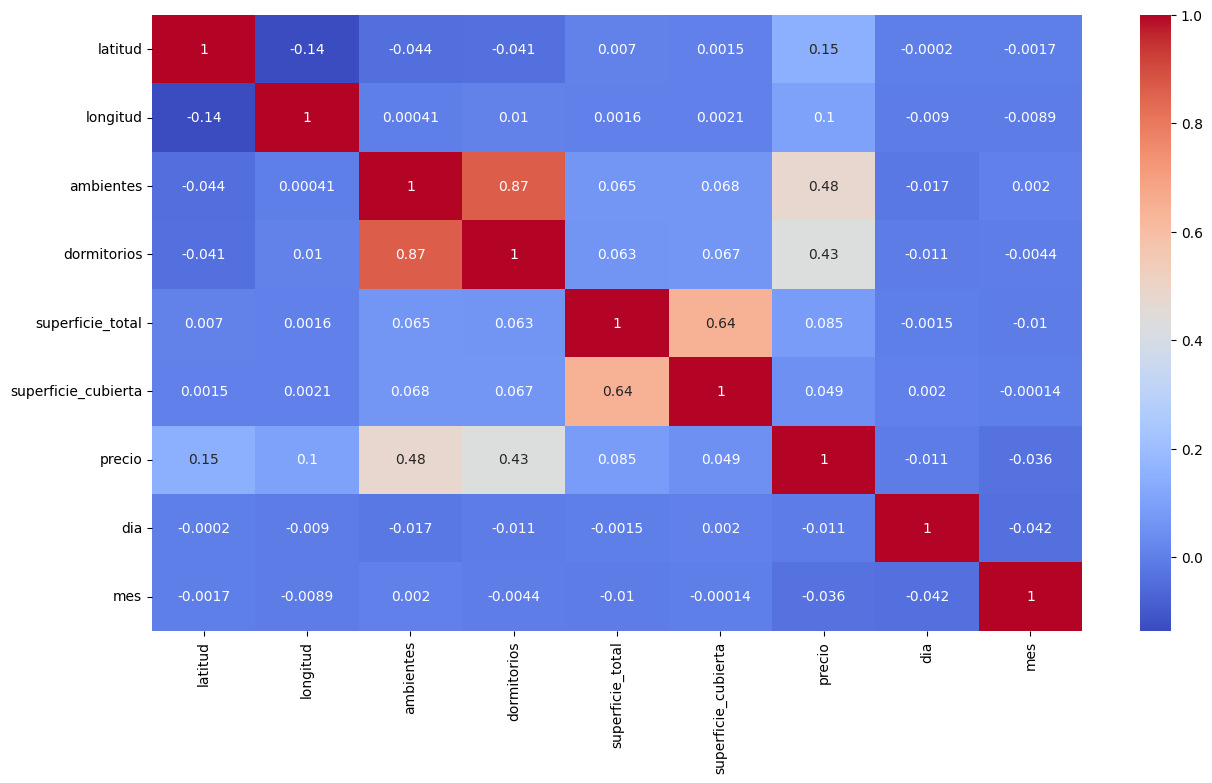

In [49]:
# Grafico la matriz de correlación en un Heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(matriz_corr, annot=True, cmap="coolwarm")

Se ve cierta correlacion positiva media entre:
* Precio y Ambientes
* Precio y Dormitorios 

Naturalmente tambien vemos una correlacion mas fuerte entre:
* Superficie total y cubierta
* Ambientes y Dormitorios.

A continuacion exploremos estas correlaciones en mas detalle.

##### Dispersograma ambientes vrs precio

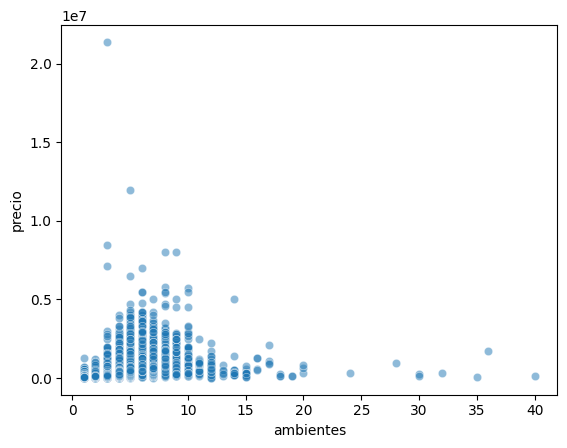

In [50]:
grf = sns.scatterplot(data=df, x="ambientes", y="precio", alpha=0.5)

##### Dispersograma dormitorios vrs precio

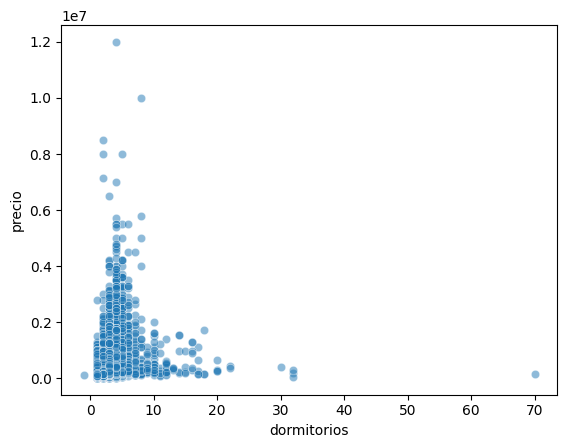

In [51]:
grf = sns.scatterplot(data=df, x="dormitorios", y="precio", alpha=0.5)

##### Dispersograma ambientes vrs superficie_total

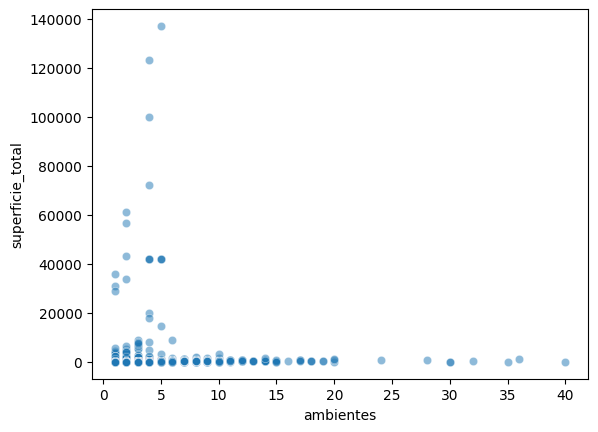

In [52]:
grf = sns.scatterplot(data=df, x="ambientes", y="superficie_total", alpha=0.5)

##### Dispersograma ambientes vrs superficie_cubierta

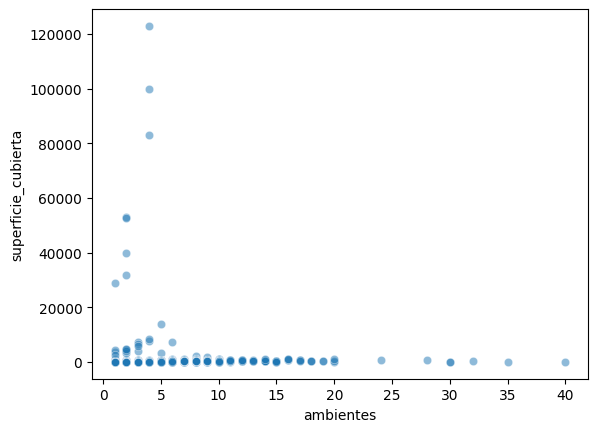

In [53]:
grf = sns.scatterplot(data=df, x="ambientes", y="superficie_cubierta", alpha=0.5)

##### Dispersograma ambientes vrs dormitorios

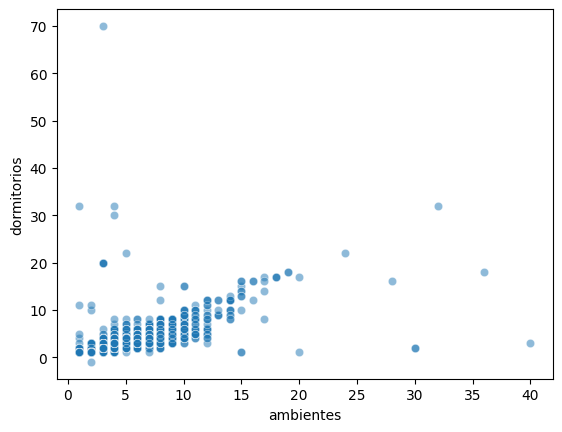

In [54]:
grf = sns.scatterplot(data=df, x="ambientes", y="dormitorios", alpha=0.5)

##### Dispersograma superficie_total vrs superficie_cubierta

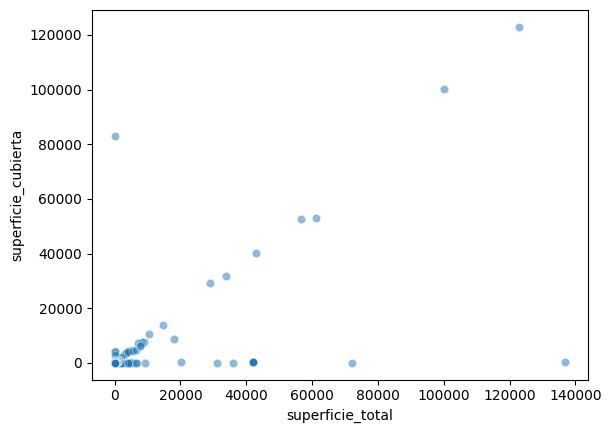

In [55]:
grf = sns.scatterplot(data=df, x="superficie_total", y="superficie_cubierta", alpha=0.5)

#### Veamos la relacion entre algunos de los otros features

##### Dispersograma barrio vrs tipo

In [56]:
pd.crosstab(df["barrio"], df["tipo"])

tipo,Casa,Departamento,PH
barrio,,,
Abasto,5,192,5
Agronomía,26,108,86
Almagro,36,3140,317
Balvanera,19,2056,163
Barracas,81,842,182
Barrio Norte,19,2478,44
Belgrano,197,7013,202
Boca,23,268,49
Boedo,78,790,258


#### **c) Valores atípicos:** 
Analizar la existencia de valores atípicos
* Detectar valores atípicos en los datos tanto en forma univariada como
multivariada. Realizar gráficos que permitan visualizar los valores atípicos.
* Explicar qué características poseen los datos atípicos detectados.
* Decidir el tratamiento a aplicar sobre los mismos.
* Analizar la relación entre el precio de venta y los metros de superficie ¿hay
valores atípicos que no se detectaron previamente?

##### Precio

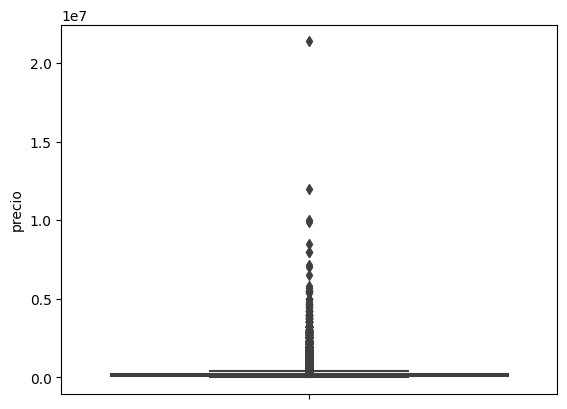

In [57]:
# sns.set(rc={"figure.figsize":(10, 45)})
sns.boxplot(y=df.precio)
plt.show()

Verifiquemos las propiedades con precios muy alejados, en este caso elegimos el umbral de 2.500.000:

In [58]:
outlier = df[df["precio"] > 2500000]
outlier

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,titulo,dia,mes
48,-34.576741,-58.404830,Palermo,Departamento,NaN,4.0,400.0,NaN,2700000.0,Departamento - Palermo Chico,9,9
197,-34.605781,-58.376705,San Nicolás,Departamento,NaN,NaN,10500.0,10500.0,9900000.0,EDIFICIO A TERMINAR DE 900M2- EXCELENTE UBICAC...,9,9
872,-34.577484,-58.405751,Palermo,Departamento,5.0,3.0,535.0,220.0,2800000.0,VENTA con RENTA hasta Feb 2020 TORRES DE GELL...,20,9
886,-34.567172,-58.430634,Palermo,Departamento,5.0,4.0,390.0,390.0,2900000.0,VENTA Torre MARIO R. ALVAREZ piso de máxima ca...,20,9
1272,NaN,NaN,Palermo,Casa,NaN,4.0,550.0,480.0,2990000.0,VENTA excelente CASA en el corazón de BARRIO P...,9,2
...,...,...,...,...,...,...,...,...,...,...,...,...
75844,-34.574818,-58.421237,Palermo,Departamento,5.0,3.0,400.0,400.0,2890000.0,Venta ó alquiler semipiso de 5 ambientes con 3...,4,5
75847,-34.576855,-58.410590,Palermo,Departamento,8.0,4.0,489.0,454.0,2950000.0,"Emblematico edificio en Plaza Alemania, 489 m2...",4,5
80329,-34.581524,-58.403588,Palermo,Departamento,10.0,6.0,520.0,500.0,3300000.0,Venta Departamento Palermo,8,5
80514,NaN,NaN,Palermo,Casa,NaN,4.0,405.0,405.0,3200000.0,Casa en venta en palermo chico,5,1


In [59]:
print(df["precio"].describe())

count    8.082300e+04
mean     2.143545e+05
std      2.855791e+05
min      5.000000e+03
25%      9.500000e+04
50%      1.400000e+05
75%      2.300000e+05
max      2.140000e+07
Name: precio, dtype: float64


##### Outliers de Precio segun el tipo de vivienda

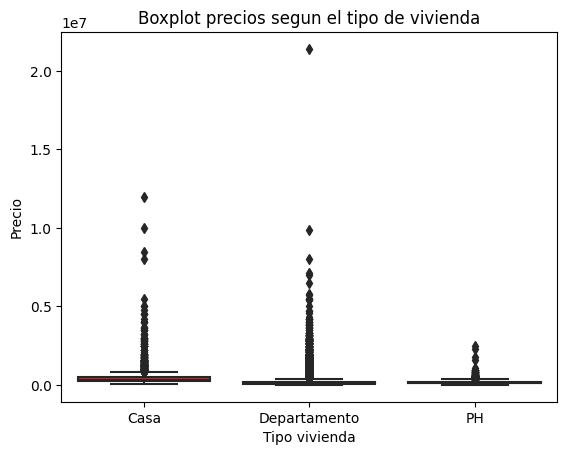

In [60]:
# sns.set(rc={"figure.figsize":(10, 45)})
sns_boxplot_fare_pclass = sns.boxplot(
    x="tipo", y="precio", data=df, palette=["r", "b", "g"]
).set(
    title="Boxplot precios segun el tipo de vivienda",
    xlabel="Tipo vivienda",
    ylabel="Precio",
)

+ Destaca el outlier en Departamentos, veamoslo en detalle:

In [61]:
df_depto = df[df["tipo"] == "Departamento"]
df_depto[df_depto["precio"] > 20000000]

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,titulo,dia,mes
11851,-34.616044,-58.458621,Caballito,Departamento,3.0,NaN,68.0,64.0,21400000.0,Departamento venta,25,1


Consideramos que por el precio de 21.400.000,0 y una superficie mas bien pequena, la propiedad es invalida y la borramos.

In [62]:
idx = df_depto[df_depto["precio"] > 20000000].index
df.drop(idx, inplace=True)

+ Hay 4 outliers mas alejados entre las Casas:

In [63]:
df_casa = df[df["tipo"] == "Casa"]
df_casa[df_casa["precio"] > 6000000]

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,titulo,dia,mes
16853,-34.572494,-58.462433,Belgrano,Casa,5.0,4.0,3197.0,3367.0,12000000.0,Casa - Belgrano R,26,3
28396,-34.565947,-58.442326,Belgrano,Casa,9.0,5.0,1763.0,1763.0,8000000.0,Casa Estilo Frances en Venta y/o Alquiler | V...,12,5
29732,-34.608300,-58.371200,Monserrat,Casa,3.0,2.0,225.0,93.0,8500000.0,Oportunidad al Costo! Venta Preciosa Casa a Es...,17,2
59190,-34.593634,-58.377164,Retiro,Casa,NaN,8.0,1166.0,1485.0,10000000.0,Basavilbaso y Arenales Espectacular casa. Embl...,17,9


Notamos que por la relacion entre superficie y precio, la Casa en Monserrat no entra dentro de los limites razonables y la borramos.

In [64]:
idx = (
    df_casa[df_casa["precio"] > 6000000]
    .iloc[
        [2],
    ]
    .index
)
# Y los eliminamos
df.drop(idx, inplace=True)

##### Veamos las distribuciones de los precios segun el tipo de vivienda:

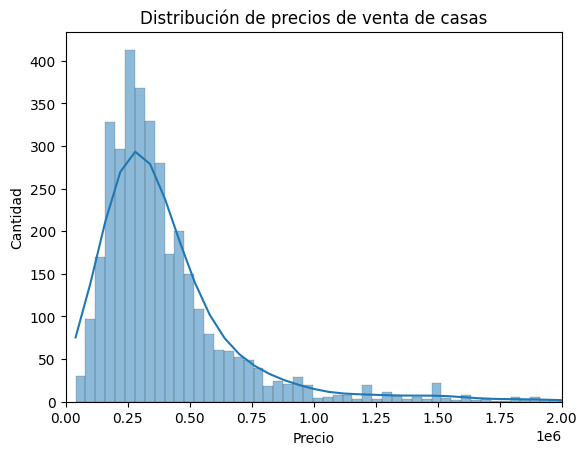

In [65]:
plt.figure(dpi=100)
h_casa = sns.histplot(df_casa["precio"], bins=300, kde=True)
h_casa = h_casa.set(
    title="Distribución de precios de venta de casas",
    xlim=(0, 2000000),
    xlabel="Precio",
    ylabel="Cantidad",
)

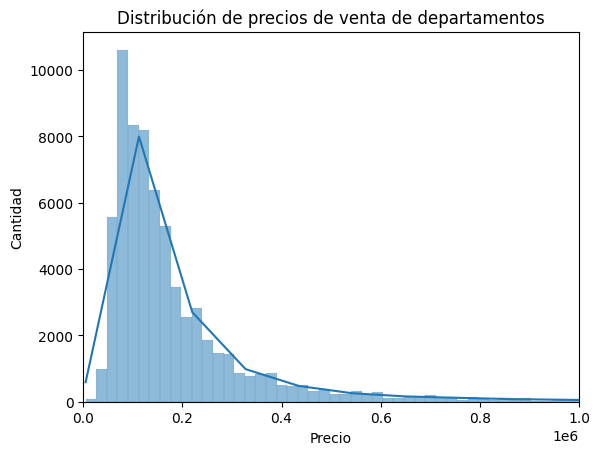

In [66]:
plt.figure(dpi=100)
h_depto = sns.histplot(df_depto["precio"], bins=1000, kde=True)
h_depto = h_depto.set(
    title="Distribución de precios de venta de departamentos",
    xlim=(0, 1000000),
    xlabel="Precio",
    ylabel="Cantidad",
)

In [67]:
df_ph = df[df["tipo"] == "PH"]

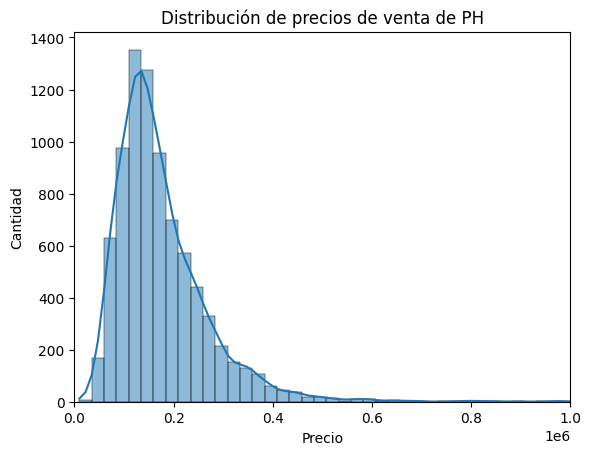

In [68]:
plt.figure(dpi=100)
h_ph = sns.histplot(df_ph["precio"], bins=100, kde=True)
h_ph = h_ph.set(
    title="Distribución de precios de venta de PH",
    xlim=(0, 1000000),
    xlabel="Precio",
    ylabel="Cantidad",
)

##### Distribucion de precios (con log)

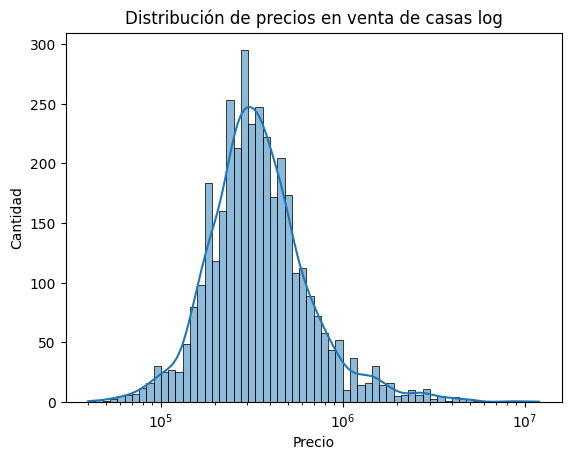

In [69]:
plt.figure(dpi=100)
h_casa2 = sns.histplot(df_casa["precio"], kde=True, log_scale=True)
h_casa2 = h_casa2.set(
    title="Distribución de precios en venta de casas log",
    xlabel="Precio",
    ylabel="Cantidad",
)

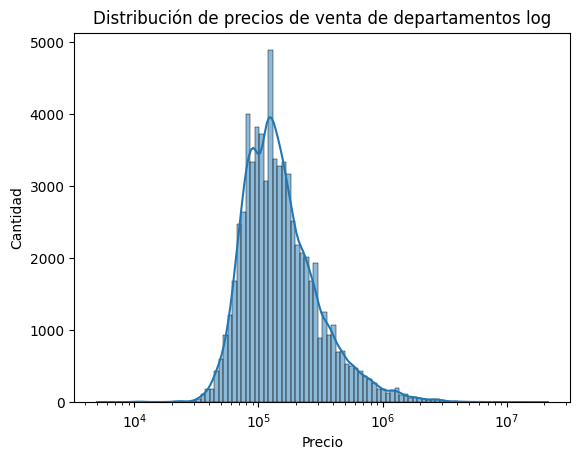

In [70]:
plt.figure(dpi=100)
h_depto2 = sns.histplot(df_depto["precio"], bins=100, kde=True, log_scale=True)
h_depto2 = h_depto2.set(
    title="Distribución de precios de venta de departamentos log",
    xlabel="Precio",
    ylabel="Cantidad",
)

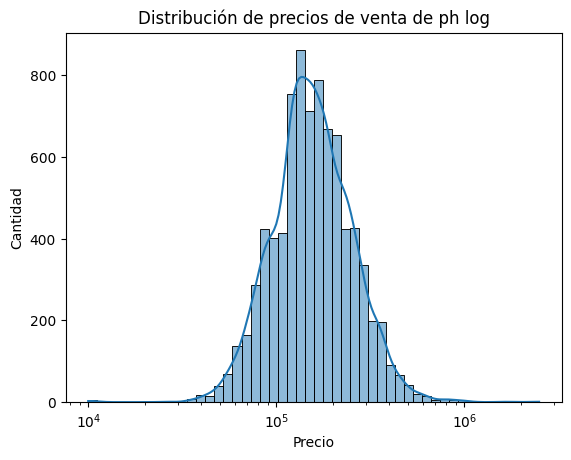

In [71]:
plt.figure(dpi=100)
h_ph2 = sns.histplot(df_ph["precio"], bins=50, kde=True, log_scale=True)
h_ph2 = h_ph2.set(
    title="Distribución de precios de venta de ph log",
    xlabel="Precio",
    ylabel="Cantidad",
)

##### Ambientes

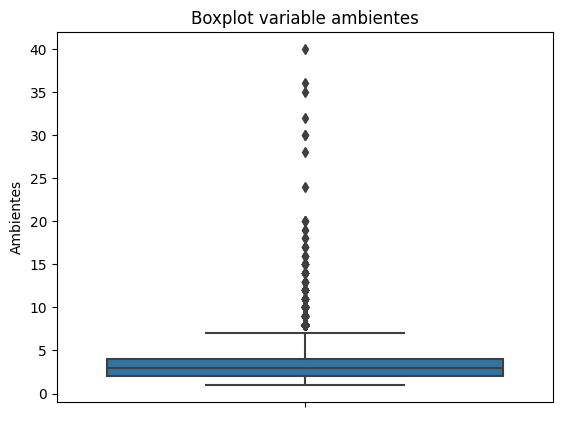

In [72]:
# Boxplot de la variable ambientes
grf_box = sns.boxplot(y="ambientes", data=df).set(
    title="Boxplot variable ambientes", xlabel=" ", ylabel="Ambientes"
)

Podemos observar multiples outliers, muchos de ellos extremos.

Veamos con mas detenimiento las propiedades con mas de 25 ambientes, un umbral razonable para un primer vistazo siendo que trabajamos solamente con propiedades de tipo vivienda.

In [73]:
outlier_rooms = df[df.ambientes > 25]
outlier_rooms

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,titulo,dia,mes
4134,-34.616391,-58.456038,Caballito,Departamento,30.0,2.0,79.0,79.0,230000.0,C/DEP COCH Y BAULERA - SEGUI AL 700 - Caballito,15,3
10137,-34.649872,-58.483012,Parque Avellaneda,PH,30.0,2.0,72.0,60.0,123500.0,PH - Parque Avellaneda,7,2
17648,-34.633236,-58.480313,Floresta,PH,32.0,32.0,535.0,435.0,300000.0,"Hotel Familiar, 32 Habitaciones",3,8
28273,NaN,NaN,Tribunales,Departamento,36.0,18.0,1348.0,NaN,1700000.0,Departamento - Tribunales,19,8
28902,-34.642037,-58.438995,Parque Chacabuco,Departamento,35.0,NaN,37.0,33.0,67000.0,Venta Departamento monoambiente balcón full am...,24,3
62951,-34.588742,-58.422459,Palermo,Departamento,40.0,3.0,75.0,68.0,145000.0,SOLER 4400 - PALERMO - DPTO 4 AMB C/ BALCON AL...,18,11
68131,-34.570959,-58.458106,Belgrano,Casa,28.0,16.0,845.0,845.0,950000.0,Imponente casa inglesa de 3 plantas S.S. en ...,5,5


Vemos que salvo la casa inglesa, los demas no son posibles. Procedemos a borrar todos excepto la casa y dos propiedades que podemos ver que se pueden arreglar gracias a contexto adicional que nos da el titulo.

In [74]:
# Seleccionamos todos menos la casa inglesa
idx = np.delete(outlier_rooms.index, [4, 5, 6])
# # Y los eliminamos
df.drop(idx, inplace=True)

Hagamos una segunda pasada y veamos en detalle las propiedades con 15 ambientes o mas:

In [75]:
outlier_rooms = df[df.ambientes >= 15]
outlier_rooms

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,titulo,dia,mes
586,-34.623590,-58.401566,San Cristobal,PH,15.0,15.0,355.0,215.0,220000.0,PH 15 AMBIENTES HOTEL A RECICLAR San Cristóbal,20,2
6255,-34.607195,-58.386465,San Nicolás,PH,15.0,14.0,325.0,228.0,170000.0,VENTA PH EN DOS PLANTAS A RECICLAR IDEAL HOTEL...,17,5
6471,-34.632698,-58.360514,Boca,PH,19.0,18.0,372.0,318.0,159000.0,PH 18 HABITACIONES AV ALMTE BROWN LA BOCA,8,2
17722,-34.590064,-58.395623,Recoleta,Casa,17.0,8.0,616.0,616.0,2100000.0,"Venta,casa,17 amb ,recoleta Con pileta",3,8
18628,-34.612216,-58.384667,Monserrat,Departamento,15.0,14.0,268.0,268.0,200000.0,Piso en Venta en Monserrat - Ideal Hostel - A ...,24,9
22404,-34.598070,-58.444686,Villa Crespo,PH,17.0,17.0,689.0,598.0,1100000.0,PH 17 AMBIENTES - VILLA CRESPO,7,12
23788,-34.600688,-58.514393,Villa Devoto,Casa,15.0,10.0,428.0,348.0,390000.0,"Venta casa geriátrico en lote 8,66x29,45",25,9
23805,-34.619163,-58.371500,San Telmo,PH,15.0,1.0,33.0,33.0,75000.0,PH - San Telmo,4,8
28902,-34.642037,-58.438995,Parque Chacabuco,Departamento,35.0,NaN,37.0,33.0,67000.0,Venta Departamento monoambiente balcón full am...,24,3
29339,-34.597022,-58.385681,Barrio Norte,PH,17.0,14.0,836.0,836.0,950000.0,PH Uso Comercial - Barrio Norte,3,2


Podemos hacer hacer varias observaciones:

* Encontramos un monoambiente que figura con 35 ambientes, que ya habiamos visto antes.
* Hay un segundo monoambiente que figura con 15 ambientes.
* Un departamento de 4 ambientes que figura con 40, que tambien ya habiamos detectado como reparable.

Podemos arreglarlas gracias a los datos que nos aporta el titulo de la publicacion:

In [76]:
# Vemos las observaciones que nombramos
df.loc[[28902, 62951, 76275]]

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,titulo,dia,mes
28902,-34.642037,-58.438995,Parque Chacabuco,Departamento,35.0,NaN,37.0,33.0,67000.0,Venta Departamento monoambiente balcón full am...,24,3
62951,-34.588742,-58.422459,Palermo,Departamento,40.0,3.0,75.0,68.0,145000.0,SOLER 4400 - PALERMO - DPTO 4 AMB C/ BALCON AL...,18,11
76275,-34.583565,-58.400343,Recoleta,Departamento,15.0,1.0,37.0,37.0,82000.0,Departamento en venta de 37.20 m2 un ambiente...,25,8


In [77]:
# Arreglamos el primer monoambiente
df.loc[28902, "ambientes"] = 1
df.loc[28902, "dormitorios"] = 1
# Arreglamos el segundo monoambiente
df.loc[76275, "ambientes"] = 1
# Arreglamos el departamento de 4 amb
df.loc[62951, "ambientes"] = 4

In [78]:
# Volvemos a buscar, asi ignoramos los datos que ya arreglamos
outlier_rooms = df[df.ambientes >= 15]

Ademas podemos observar que:

* Con excepcion de las casas, que simplemente parecen ser propiedades grandes, el resto presenta valores inusuales.
* Esto se ve facilmente en Departamentos pero tambien podemos ver que los PHs son en su mayoria Edificios en bloque u Hoteles.

Como estas propiedades que nombramos no cumplen realmente con el criterio de ser del tipo Vivienda, las borramos:

In [79]:
# Seleccionamos todos menos las casas
idx = outlier_rooms[outlier_rooms.tipo != "Casa"].index
# Y los eliminamos
df.drop(idx, inplace=True)

Volvamos a ver el boxplot luego de eliminar los outliers.

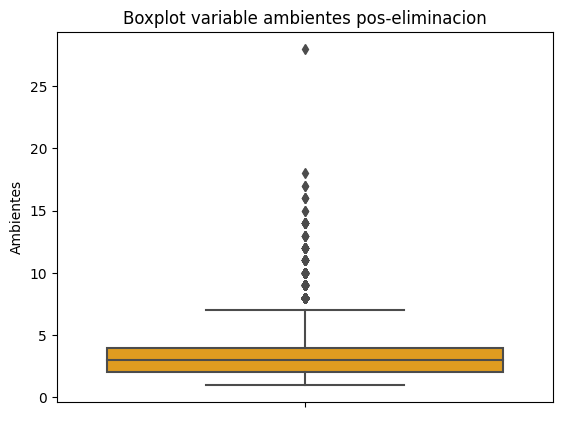

In [80]:
# Volvemos a graficar un boxplot despues de eliminar algunos outliers
grf_box = sns.boxplot(y="ambientes", data=df, color="orange").set(
    title="Boxplot variable ambientes pos-eliminacion", xlabel=" ", ylabel="Ambientes"
)

##### Dormitorios

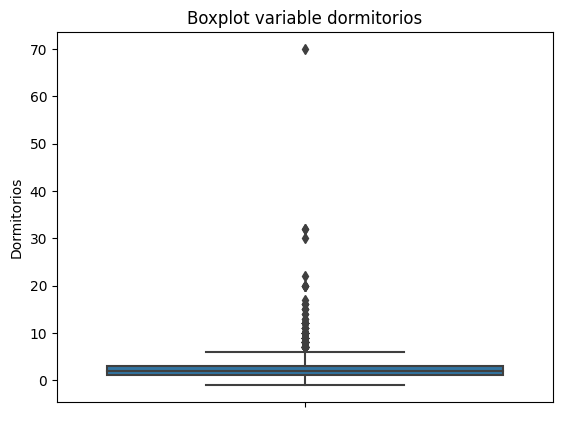

In [81]:
# Boxplot de la variable dormitorios
grf_box = sns.boxplot(y="dormitorios", data=df).set(
    title="Boxplot variable dormitorios", xlabel=" ", ylabel="Dormitorios"
)

Nuevamente vemos multiples outliers, algunos de ellos extremos. Veamos las propiedades con mas de 10 dormitorios.

In [82]:
outlier_bedrooms = df[df.dormitorios > 10]
outlier_bedrooms

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,titulo,dia,mes
3122,-34.620137,-58.374386,San Telmo,PH,12.0,12.0,688.0,350.0,600000.0,"PH sin expensas!!, con gran patio y terraza pr...",22,4
3235,-34.562809,-58.476758,Congreso,Casa,NaN,11.0,NaN,200.0,239000.0,En venta hermosa casa antigua reciclada zona C...,10,6
7136,-34.576061,-58.421289,Palermo,Departamento,3.0,20.0,127.0,117.0,650000.0,Departamento - Palermo,21,9
8037,-34.614573,-58.480650,Villa del Parque,Departamento,2.0,11.0,14.0,35.0,95000.0,Departamento 2 ambientes al frente con Balcón ...,19,7
9404,-34.608645,-58.485619,Villa del Parque,Departamento,4.0,32.0,83.0,75.0,189000.0,Departamento 4 ambientes a estrenar en duplex ...,14,3
9719,-34.630186,-58.389156,Parque Patricios,Departamento,1.0,32.0,32.0,32.0,52000.0,Depto 1 ambiente amplio apto profesional,16,10
10192,-34.594430,-58.396078,Recoleta,Departamento,14.0,12.0,660.0,600.0,1400000.0,Ayacucho * 1200 . Piso. APTO COMERCIAL. Sup...,1,8
12724,-34.580976,-58.495637,Villa Pueyrredón,Casa,11.0,11.0,341.0,341.0,360000.0,"Casa, cochera, terrazas, patio, Villa Pueyrredón",15,5
16638,-34.604498,-58.385295,San Nicolás,Departamento,12.0,12.0,237.0,209.0,146000.0,DEPARTAMENTO A REFACCIONAR · TALCAHUANO AL 300...,5,2
16937,-34.591110,-58.400685,Recoleta,Departamento,4.0,30.0,148.0,138.0,380000.0,Departamento. Recoleta. Balcón terraza. Silenc...,26,3


Podemos ver que las siguientes 3 propiedades con valores anomalos de dormitorios las podemos arreglar con ayuda de contexto extra de sus titulos:

In [83]:
# Seleccionamos algunas observaciones
df.loc[[8037, 9719, 27108]]

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,titulo,dia,mes
8037,-34.614573,-58.480650,Villa del Parque,Departamento,2.0,11.0,14.0,35.0,95000.0,Departamento 2 ambientes al frente con Balcón ...,19,7
9719,-34.630186,-58.389156,Parque Patricios,Departamento,1.0,32.0,32.0,32.0,52000.0,Depto 1 ambiente amplio apto profesional,16,10
27108,-34.588454,-58.385257,Recoleta,Departamento,5.0,22.0,NaN,144.0,430000.0,Departamento de 2 dormitorios con balcón en ve...,8,12


In [84]:
# Arreglamos el primer departamento
df.loc[8037, "dormitorios"] = 1
# Arreglamos el segundo departamento
df.loc[9719, "dormitorios"] = 1
# Arreglamos el departamento de 2 dormitorios
df.loc[27108, "dormitorios"] = 2

Mientras que las siguientes 3 propiedades resaltan porque parecen especificamente ser no viviendas, es decir hoteles, edificios, etc. Procedemos a borrarlas:

In [85]:
# Seleccionamos algunas observaciones
df.loc[[35934, 43803, 51745]]

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,titulo,dia,mes
35934,-34.623793,-58.402256,San Cristobal,Casa,NaN,13.0,368.0,NaN,350000.0,"Casa con 6 dptos tipo ph en BLOCK, IDEAL PARA ...",8,1
43803,-34.625327,-58.372727,San Telmo,Casa,10.0,15.0,264.0,242.0,950000.0,VENTA - Hotel estilo art noveau San Telmo.,21,5
51745,-34.617989,-58.391655,San Cristobal,Casa,10.0,15.0,515.0,425.0,400000.0,EDIFICIO EN SAN CRISTOBAL!!!,16,6


In [86]:
idx = [35934, 43803, 51745]
# Y los eliminamos
df.drop(idx, inplace=True)

Luego tomamos todas las propiedades restantes con excepcion de las casas que parecen ser simplemente propiedades grandes dentro de lo razonable y procedemos a eliminarlas.

In [87]:
# Actualizamos luego de los cambios
outlier_bedrooms = df[df.dormitorios > 10]
# Seleccionamos todos menos las casas
idx = outlier_bedrooms[outlier_bedrooms.tipo != "Casa"].index
# Y los eliminamos
df.drop(idx, inplace=True)

Nos fijamos nuevamente en el boxplot luego de la eliminacion de los outliers extremos.

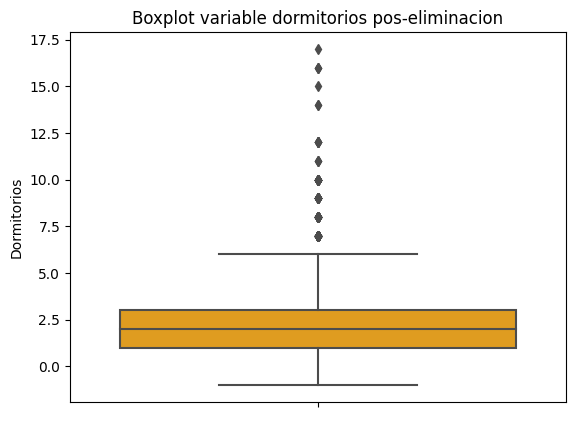

In [88]:
# Volvemos a graficar un boxplot despues de eliminar algunos outliers
grf_box = sns.boxplot(y="dormitorios", data=df, color="orange").set(
    title="Boxplot variable dormitorios pos-eliminacion",
    xlabel=" ",
    ylabel="Dormitorios",
)

##### Superficie Total

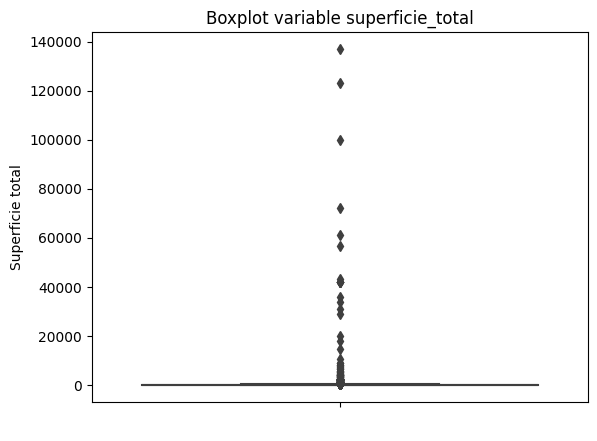

In [89]:
# Boxplot de la variable superficie total
grf_box = sns.boxplot(y="superficie_total", data=df).set(
    title="Boxplot variable superficie_total", xlabel=" ", ylabel="Superficie total"
)

Se observa una gran cantidad de outliers y muy extremos.

Busquemos observaciones mayores a 5mil m2:

In [90]:
outlier_sfc_total = df[df.superficie_total > 5000]
# Verificamos si son valores posibles
outlier_sfc_total

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,titulo,dia,mes
197,-34.605781,-58.376705,San Nicolás,Departamento,NaN,NaN,10500.0,10500.0,9900000.0,EDIFICIO A TERMINAR DE 900M2- EXCELENTE UBICAC...,9,9
14297,-34.578917,-58.429373,Palermo,Departamento,2.0,1.0,61130.0,53030.0,225000.0,VENTA DEPARTAMENTO 2 AMBIENTES PALERMO C/AMENI...,29,5
14363,-34.600113,-58.403649,Balvanera,Departamento,2.0,1.0,33800.0,31670.0,66000.0,VENTA 2 AMBIENTES CON RENTA,29,5
16565,-34.588175,-58.396261,Recoleta,Departamento,1.0,NaN,36000.0,30.0,90000.0,Departamento Monoambiente alquiler temporario ...,5,2
18609,-34.614279,-58.361092,Caballito,Departamento,2.0,1.0,5312.0,4809.0,145000.0,VENTA - EMPRENDIMIENTO DEPARTAMENTO 2 AMBIENTES,24,9
20621,-34.587320,-58.401556,Barrio Norte,Departamento,2.0,1.0,56740.0,52540.0,175000.0,EXCELENTE DEPARTAMENTO DE 2 AMBIENTES DE CATEG...,11,3
22875,-34.550093,-58.483034,Saavedra,Departamento,2.0,1.0,43086.0,40038.0,114000.0,"Venta Departamento 2 amb a Estrenar, Saavedra.",18,8
24603,-34.579163,-58.455725,Colegiales,Departamento,1.0,NaN,31000.0,26.0,51100.0,Av. Alvarez Thomas 970 - Colegiales - Capital ...,5,10
24930,-34.599421,-58.386867,Barrio Norte,Departamento,5.0,3.0,137000.0,135.0,390000.0,Alquiler Divino 5 Amb. - 137 M² en Barrio Norte,1,7
28682,-34.629203,-58.437124,Caballito,PH,3.0,2.0,5736.0,57.0,169000.0,Excelente PH de 3 Ambientes con Terraza Propia -,24,3


Vemos que hay valores que posiblemente tengan ceros de mas, los borramos.

In [91]:
idx = outlier_sfc_total.index
# Y procedemos a borrarlos, mas adelante se podria intentar salvarlos
df.drop(idx, inplace=True)

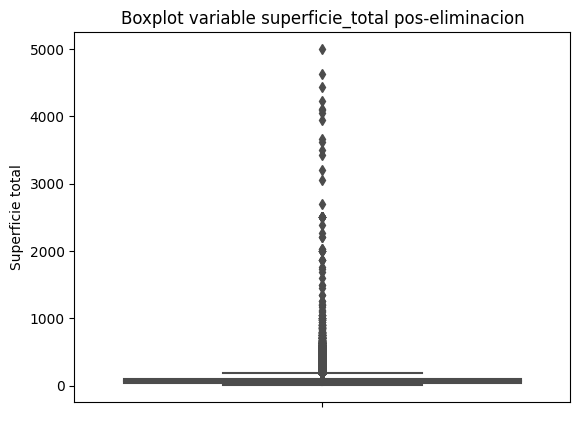

In [92]:
# Volvemos a graficar un boxplot despues de eliminar algunos outliers
grf_box = sns.boxplot(y="superficie_total", data=df, color="orange").set(
    title="Boxplot variable superficie_total pos-eliminacion",
    xlabel=" ",
    ylabel="Superficie total",
)

Elegimos un umbral que nos parezca razonable, despues de haber visto mejor los datos, para buscar outliers invalidos.

Buscamos observaciones mayores a mil m2 pero menos de 5 ambientes en primera instancia.

In [93]:
outlier_sfc_rooms = df[
    df.apply(
        lambda x: x["superficie_total"] > 1000 and x["ambientes"] < 5,
        axis=1,
    )
]
# Verificamos si son valores posibles
outlier_sfc_rooms

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,titulo,dia,mes
357,-34.584521,-58.424260,Palermo,Departamento,2.0,1.0,2032.0,37.0,87000.0,Departamento/Venta/2 Ambientes/Excelente/Palermo,17,12
6490,-34.634196,-58.465152,Flores,Departamento,1.0,1.0,4428.0,31.0,58552.0,Departamento - Flores,8,2
6700,-34.554356,-58.458076,Belgrano,Departamento,2.0,1.0,2500.0,51.0,189850.0,VENTA DEPARTAMENTO 2 AMBIENTES PISO ALTO BELGRANO,8,2
6709,-34.557903,-58.452293,Belgrano,Departamento,4.0,3.0,5000.0,109.0,418000.0,VENTA DEPARTAMENTO 3-4 AMBIENTES COCHERA BELG...,8,2
6796,-34.611660,-58.393440,Balvanera,Departamento,2.0,1.0,2383.0,37.0,64000.0,VENTA HERMOSO 2 AMBIENTES BALVANERA. OPORTUNIDAD,8,2
6840,-34.628565,-58.445791,Caballito,Departamento,4.0,3.0,2000.0,162.0,449900.0,VENTA DEPARTAMENTO 4 AMBIENTES C/COCHERA CABAL...,8,2
7024,-34.573000,-58.481100,Villa Urquiza,Departamento,1.0,NaN,3660.0,33.0,98000.0,Venta Depto monoambiente a estrenar villa Urquiza,8,2
7026,-34.573375,-58.480012,Villa Urquiza,Departamento,2.0,1.0,3500.0,60.0,169000.0,Departamento dos ambientes Villa Urquiza. Est...,8,2
11648,-34.563005,-58.453674,Belgrano,Departamento,3.0,2.0,2500.0,66.0,289500.0,VENTA DEPARTAMENTO 3 AMB COCHERA BELGRANO,13,3
11654,-34.563005,-58.453674,Belgrano,Departamento,3.0,2.0,2500.0,66.0,299900.0,VENTA DEPARTAMENTO 3 AMB COCHERA BELGRANO,13,3


Vemos que son valores que posiblemente tengan ceros de mas, si bien se podria intentar arreglar el dato de superficie_total con el de superficie_cubierta preferimos borrarlos al ser tan pocos y para no introducir datos erroneos.

In [94]:
idx = outlier_sfc_rooms.index
# Procedemos a borrarlos, mas adelante se podria intentar salvarlos
df.drop(idx, inplace=True)

Volvemos a realizar el mismo proceso, con un nuevo umbral para intentar detectar otros outliers invalidos.

Buscamos observaciones mayores a 500 m2 pero menos de 4 ambientes.

In [95]:
outlier_sfc_rooms = df[
    df.apply(
        lambda x: x["superficie_total"] > 500 and x["ambientes"] < 4,
        axis=1,
    )
]
# Verificamos si son valores posibles
outlier_sfc_rooms

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,titulo,dia,mes
9415,-34.613200,-58.471100,Villa General Mitre,PH,3.0,4.0,800.0,720.0,495000.0,Venta en block- 4 PH +Jardín+Depósito. Villa M...,15,8
27422,-34.646590,-58.519538,Liniers,PH,3.0,2.0,534.0,340.0,440000.0,3 DEPARTAMENTOS DE 3 AMB MAS LOCAL S/ SUBDIVISIO,8,6
34794,-34.621995,-58.508856,Floresta,Departamento,3.0,2.0,645.0,59.0,93000.0,VENTA LUMINOSO DEPARTAMENTO 3 AMBIENTES CON BA...,7,8
41468,-34.580700,-58.413795,Palermo,Departamento,2.0,1.0,725.0,65.0,349000.0,Departamento a Estrenar 2 amb c/coch Palermo C...,9,1
41884,-34.580496,-58.429956,Palermo,Casa,1.0,NaN,1000.0,900.0,300000.0,Casa venta,8,3
42908,-34.607533,-58.477092,Villa General Mitre,Departamento,3.0,2.0,560.0,416.0,499900.0,Venta de 6 departamentos en Block Reciclados!!,20,3
76793,-34.617351,-58.499418,Monte Castro,Casa,3.0,2.0,525.0,355.0,400000.0,Casa 3 Amb c/ Galpón - Lote propio 10 x 40 - M...,23,4
80526,-34.645581,-58.472496,Parque Avellaneda,Casa,3.0,2.0,526.0,474.0,400000.0,Casa - Parque Avellaneda,5,1


Nuevamente vemos que hay valores que posiblemente tengan ceros de mas ya que no se condicen con los valores de otros features como ambientes, por ende los borramos.

In [96]:
idx = outlier_sfc_rooms.index
# Y procedemos a borrarlos, mas adelante se podria intentar salvarlos
df.drop(idx, inplace=True)

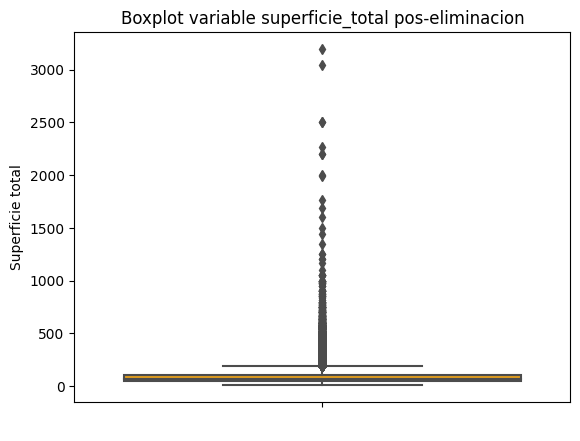

In [97]:
# Volvemos a graficar un boxplot una ultima vez luego de eliminar mas propiedades
grf_box = sns.boxplot(y="superficie_total", data=df, color="orange").set(
    title="Boxplot variable superficie_total pos-eliminacion",
    xlabel=" ",
    ylabel="Superficie total",
)

##### Superficie Cubierta

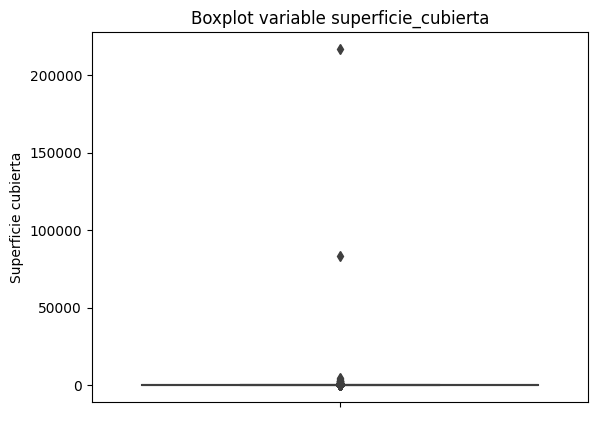

In [98]:
# Boxplot de la variable superficie cubierta
grf_box = sns.boxplot(y="superficie_cubierta", data=df).set(
    title="Boxplot variable superficie_cubierta",
    xlabel=" ",
    ylabel="Superficie cubierta",
)

Busquemos observaciones mayores a 3mil m2.


In [99]:
outlier_sfc_cov = df[df.superficie_cubierta > 3000]
outlier_sfc_cov

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,titulo,dia,mes
304,-34.637026,-58.426283,Parque Chacabuco,Casa,NaN,NaN,NaN,217000.0,250000.0,EXCEPCIONAL CASA DOS FAMILIAS - Parque Chacabuco,17,12
6011,NaN,NaN,San Telmo,Departamento,2.0,1.0,48.0,4435.0,93500.0,Dptos 2 amb a estrenar en San Telmo!!!,15,10
16853,-34.572494,-58.462433,Belgrano,Casa,5.0,4.0,3197.0,3367.0,12000000.0,Casa - Belgrano R,26,3
37200,-34.604362,-58.392366,Barrio Norte,Departamento,4.0,NaN,83.0,83000.0,155000.0,AMPLIO DEPTO EN VENTA BARRIO NORTE,25,7
62629,-34.579394,-58.453519,Colegiales,Departamento,3.0,2.0,41.0,3837.0,83000.0,Departamento - Colegiales,4,11


Otra vez nos encontramos que hay valores que posiblemente tengan ceros de mas, los borramos.


In [100]:
idx = outlier_sfc_cov.index
# Y procedemos a borrarlos, mas adelante se podria intentar salvarlos
df.drop(idx, inplace=True)

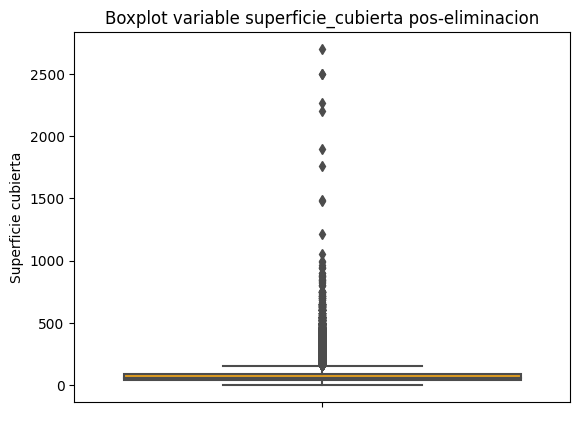

In [101]:
# Volvemos a graficar un boxplot despues de eliminar algunos outliers
grf_box = sns.boxplot(y="superficie_cubierta", data=df, color="orange").set(
    title="Boxplot variable superficie_cubierta pos-eliminacion",
    xlabel=" ",
    ylabel="Superficie cubierta",
)

Elegimos un nuevo umbral y buscamos observaciones mayores a mil m2 cubiertos pero menos de 5 ambientes.

In [102]:
outlier_covsfc_rooms = df[
    df.apply(
        lambda x: x["superficie_cubierta"] > 1000 and x["ambientes"] < 5,
        axis=1,
    )
]
# Verificamos si son valores posibles
outlier_covsfc_rooms

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,titulo,dia,mes
76588,-34.630704,-58.400901,Parque Patricios,Departamento,1.0,NaN,31.0,2700.0,71500.0,"DEPARTAMENTO - PQUE.PATRICIOS, 2 AMBIENTES, B...",27,10


Vemos que hay un valor que no es posible y procedemos a borrarlo.

In [103]:
idx = outlier_covsfc_rooms.index
# Y procedemos a borrarlo
df.drop(idx, inplace=True)

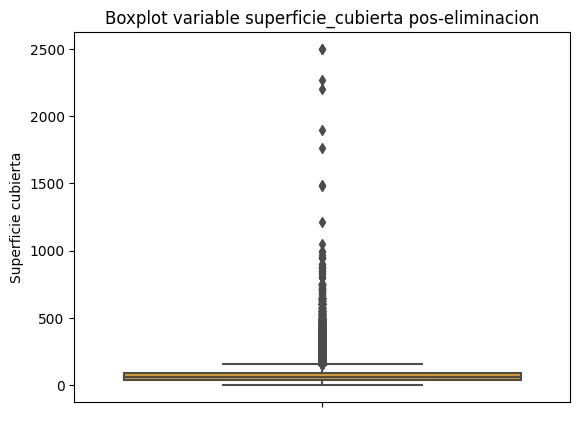

In [104]:
# Volvemos a graficar un boxplot una ultima despues de eliminar algunos outliers
grf_box = sns.boxplot(y="superficie_cubierta", data=df, color="orange").set(
    title="Boxplot variable superficie_cubierta pos-eliminacion",
    xlabel=" ",
    ylabel="Superficie cubierta",
)

##### Aclaracion sobre outliers multivariados:

Cabe aclarar que el estudio de outliers multivariados se hara mas adelante en el analisis, ya que para aplicar Mahalanobis precisamos de no contar con NaNs en las features que nos interesan, por lo que lo haremos luego de la siguiente seccion (Datos Faltantes).

#### **b) Datos Faltantes:** 
Analizar la presencia de datos faltantes en el dataset
* Realizar análisis de datos faltantes a nivel de columna. Graficar para cada variable
el porcentaje de datos faltantes con respecto al total del dataset
* Realizar un análisis de datos faltantes a nivel de fila. Calcular el porcentaje de
datos faltantes de cada registro. Realizar un gráfico que permita conocer la
proporción de faltantes por fila en el dataset.
* Determinar, de ser posible, estrategias para reparar los valores faltantes.
* En caso de realizar imputaciones comparar las distribuciones de cada atributo
reparado con la distribución anterior a la imputación de los datos faltantes.

<h4 align="center"><b> Realizar análisis de datos faltantes a nivel de columna. Graficar para cada variable
el porcentaje de datos faltantes con respecto al total del dataset </b></h4>

##### Veamos la distribucion de datos faltantes del dataset en general

In [105]:
na_ratio_column = pd.DataFrame()
na_ratio_column["Percent"] = ((df.isnull().sum() / len(df)) * 100).sort_values(
    ascending=False
)
na_ratio_column["Count"] = (df.isnull().sum()).sort_values(ascending=False)

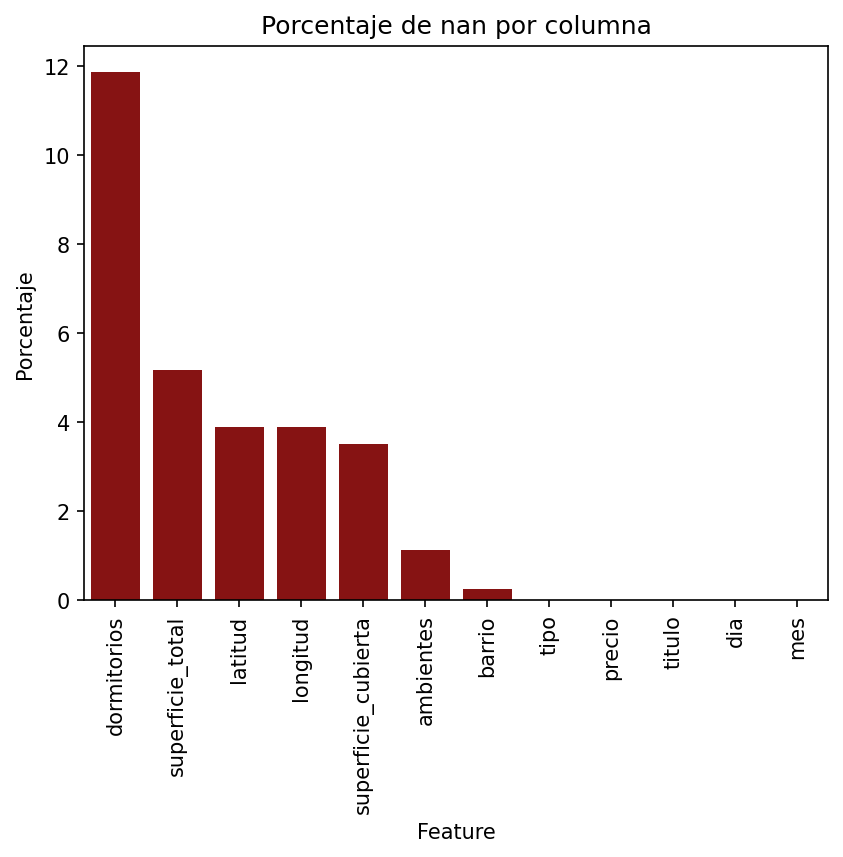

In [106]:
eje_x = na_ratio_column.index
eje_y = list(na_ratio_column["Percent"])

plt.figure(dpi=150)
sns_bar_plot = sns.barplot(x=eje_x, y=eje_y, color=(0.6, 0, 0), alpha=1)
plt.ylabel("Porcentaje")
plt.xlabel("Feature")
plt.title("Porcentaje de nan por columna")
plt.xticks(rotation=90)
plt.show()

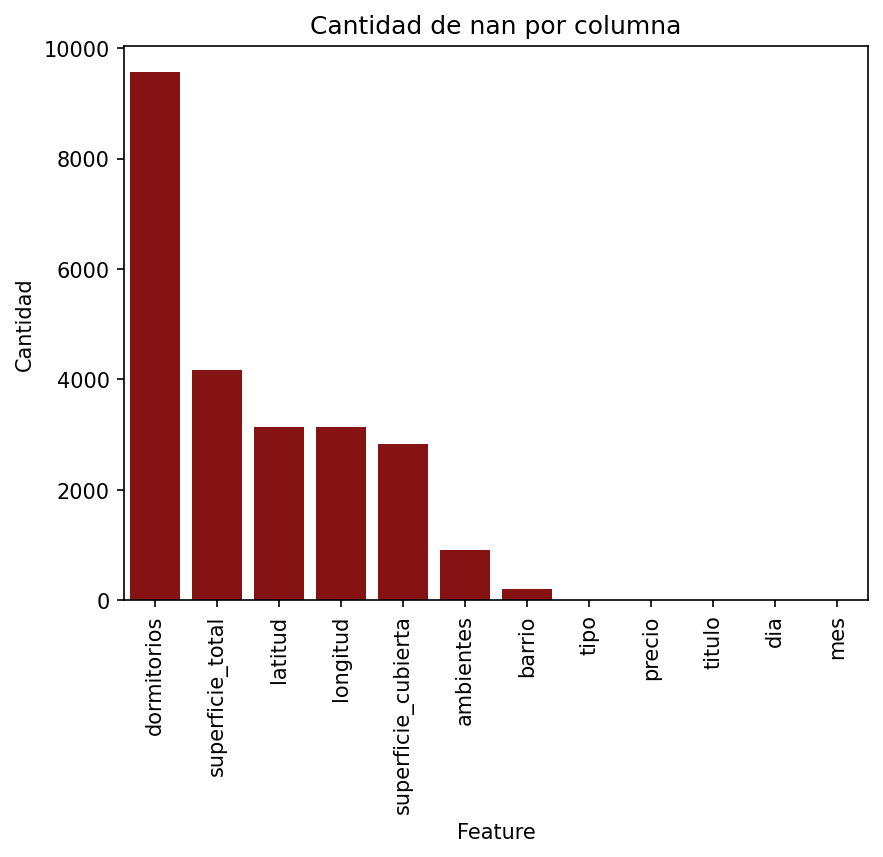

In [107]:
eje_x = na_ratio_column.index
eje_y = list(na_ratio_column["Count"])

plt.figure(dpi=150)
sns_bar_plot = sns.barplot(x=eje_x, y=eje_y, color=(0.6, 0, 0), alpha=1)
plt.ylabel("Cantidad")
plt.xlabel("Feature")
plt.title("Cantidad de nan por columna")
plt.xticks(rotation=90)
plt.show()

Vemos que los features con mayor porcentaje de datos faltantes son:
* sub_barrio
* dormitorios
* superficie_total
* latitud
* longitud
* superficie_cubierta
* ambientes

En ese orden, con sub_barrio teniendo la particularidad de estar casi 100% vacio.

<h4 align="center"><b> Realizar un análisis de datos faltantes a nivel de fila. Calcular el porcentaje de datos faltantes de cada registro. Realizar un gráfico que permita conocer la proporción de faltantes por fila en el dataset </b></h4>

In [108]:
na_ratio_row = pd.DataFrame()
n_column = df.shape[1]
na_ratio_row["Percent"] = df.isnull().sum(axis=1) / n_column
na_ratio_row["Count"] = df.isnull().sum(axis=1)

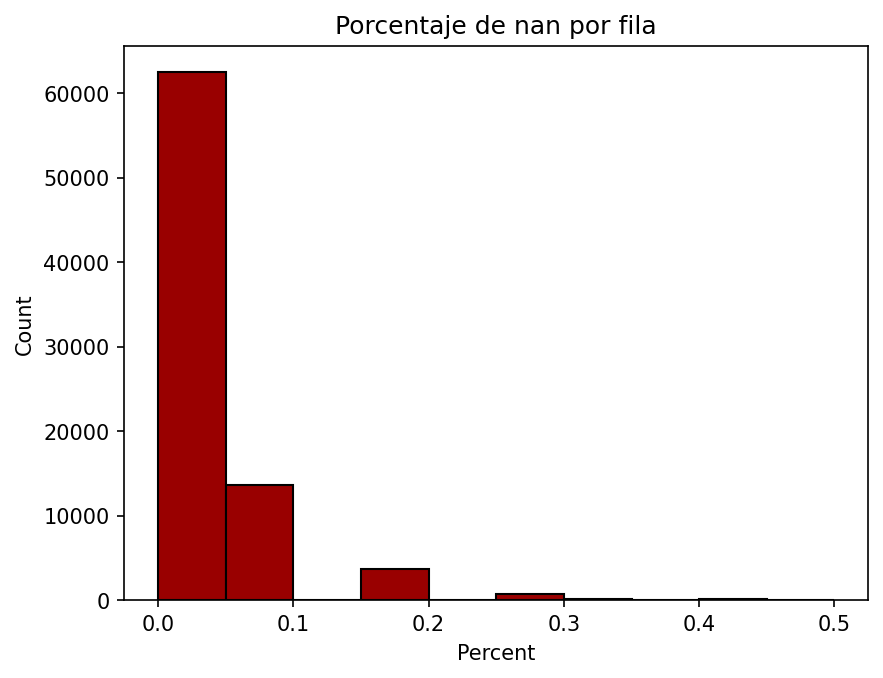

In [109]:
plt.figure(dpi=150)
sns.histplot(data=na_ratio_row, x="Percent", bins=10, color=(0.6, 0, 0), alpha=1)
plt.title("Porcentaje de nan por fila")
plt.show()

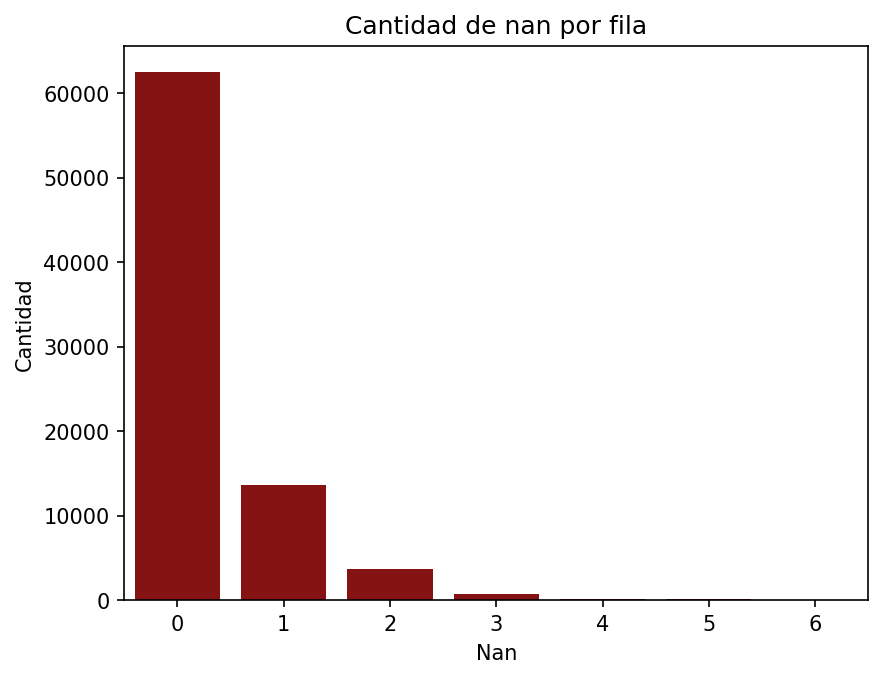

In [110]:
plt.figure(dpi=150)
sns.countplot(x="Count", data=na_ratio_row, color=(0.6, 0, 0), alpha=1)
plt.ylabel("Cantidad")
plt.xlabel("Nan")
plt.title("Cantidad de nan por fila")
plt.show()

##### Barrios

In [111]:
filas_totales = df.shape[0]
# Calculamos el porcentaje de filas nulas respecto del total de filas
barrios_nan = round(df.isna().barrio.sum() / filas_totales * 100, 3)
print(f"El feature Barrios tiene: {barrios_nan} % filas nulas")

El feature Barrios tiene: 0.253 % filas nulas


Como el porcentaje de NaNs de Barrios en relacion a las filas totales es del 0.25 ,eliminamos dichos registros

In [112]:
df = df[df["barrio"].notna()]

##### Ambientes

In [113]:
# Vemos cuantas filas tienen datos faltantes de ambientes
ambs_nan = df.ambientes.isnull().sum()
ambs_nan

874

In [114]:
filas_totales = df.shape[0]
# Calculamos el porcentaje de filas nulas respecto del total de filas
print(
    f"El feature Ambientes tiene: {round(ambs_nan / filas_totales * 100, 3)} % filas nulas"
)

El feature Ambientes tiene: 1.086 % filas nulas


In [115]:
# Borramos las filas vacias
idx = df[df.ambientes.isnull()].index
df.drop(idx, inplace=True)

In [116]:
# Vemos si hay valores negativos
(df.ambientes <= 0).any()

False

Al tener un porcentaje relativamente pequeno de datos faltantes decidimos borrar los mismos en el feature Ambientes

##### Dormitorios

In [117]:
# Vemos cuantas filas tienen datos faltantes de dormitorios
dorms_nan = df.dormitorios.isnull().sum()
dorms_nan

9055

In [118]:
filas_totales = df.shape[0]
# Calculamos el porcentaje de filas nulas respecto del total de filas
print(
    f"El feature Dormitorios tiene: {round(dorms_nan / filas_totales * 100, 3)} % filas nulas"
)

El feature Dormitorios tiene: 11.374 % filas nulas


In [119]:
# Vemos si hay valores negativos
(df.dormitorios <= 0).sum()

1

Encontramos un valor negativo, y lo borramos.

In [120]:
# Borramos el valor negativo
idx = df[df.dormitorios <= 0].index
df.drop(idx, inplace=True)

In [121]:
# Vemos cuantas propiedades tienen mas dormitorios que ambientes, lo cual no tiene sentido
df.apply(
    lambda row: True if row["ambientes"] < row["dormitorios"] else False, axis=1
).sum()

108

In [122]:
# Borramos las propiedades con mas dormitorios que ambientes
idx = df[
    df.apply(
        lambda row: True if row["ambientes"] < row["dormitorios"] else False, axis=1
    )
].index
df.drop(idx, inplace=True)

Por tener una cantidad considerablemente mayor de datos faltantes que el feature Ambientes y estar directamente relacionado con este, decidimos dejar los datos faltantes del feature Dormitorios e intentar repararlos mas adelante.

##### Superficie Total

In [123]:
# Vemos cuantas filas tienen datos faltantes de superficie_total
sup_total_nan = df.superficie_total.isnull().sum()
sup_total_nan

3932

In [124]:
filas_totales = df.shape[0]
# Calculamos el porcentaje de filas nulas respecto del total de filas
print(
    f"El feature Superficie Total tiene: {round(sup_total_nan / filas_totales * 100, 3)} % filas nulas"
)

El feature Superficie Total tiene: 4.946 % filas nulas


In [125]:
# Borramos las filas vacias
idx = df[df.superficie_total.isnull()].index
df.drop(idx, inplace=True)

In [126]:
# Vemos si hay valores negativos
(df.superficie_total <= 0).any()

False

Nos encontramos con menos del 5% del Dataset con datos nulos, al ser un porcentaje pequeno procedemos a borrarlos ya que es una feature relevante a nuestro target.

##### Superficie Cubierta

In [127]:
# Vemos cuantas filas tienen datos faltantes de superficie_cubierta
sup_cub_nan = df.superficie_cubierta.isnull().sum()
sup_cub_nan

2727

In [128]:
filas_totales = df.shape[0]
# Calculamos el porcentaje de filas nulas respecto del total de filas
print(
    f"El feature Superficie Cubierta tiene: {round(sup_cub_nan / filas_totales * 100, 3)} % filas nulas"
)

El feature Superficie Cubierta tiene: 3.609 % filas nulas


In [129]:
# Borramos las filas vacias
idx = df[df.superficie_cubierta.isnull()].index
df.drop(idx, inplace=True)

In [130]:
# Vemos si hay valores negativos
(df.superficie_cubierta <= 0).any()

False

In [131]:
# Vemos cuantas propiedades tienen mas superficie cubierta que total, lo cual no tiene sentido
df.apply(
    lambda row: True if row["superficie_total"] < row["superficie_cubierta"] else False,
    axis=1,
).sum()

160

In [132]:
# Borramos las propiedades con mas superficie cubierta que total
idx = df[
    df.apply(
        lambda row: True
        if row["superficie_total"] < row["superficie_cubierta"]
        else False,
        axis=1,
    )
].index
df.drop(idx, inplace=True)

##### Vamos a verificar que las propiedades que tenemos esten efectivamente dentro de los limites de Capital Federal, esta vez de manera mas exhaustiva:

In [133]:
import geopandas as geopd
import rtree
from geopandas.tools import sjoin
from shapely.geometry import Polygon, LineString, Point

Armamos un geodatafreame pasando longitud y latitud a variable de tipo punto:

In [134]:
gdf = geopd.GeoDataFrame(df, geometry=geopd.points_from_xy(df.longitud, df.latitud))

df = gdf

In [135]:
df[df.latitud.isna()]

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,titulo,dia,mes,geometry
44,NaN,NaN,Palermo,Departamento,3.0,2.0,85.0,85.0,200000.0,Departamento - Palermo,9,9,POINT EMPTY
72,NaN,NaN,Palermo,Departamento,2.0,1.0,50.0,50.0,153000.0,"Departamento 2 AMBIENTES en Palermo, Capital F...",9,9,POINT EMPTY
73,NaN,NaN,Palermo,Departamento,3.0,2.0,185.0,185.0,890000.0,Espectacular Loft 185 m2 en Venta en Palacio A...,9,9,POINT EMPTY
97,NaN,NaN,Belgrano,Departamento,4.0,3.0,180.0,103.0,495000.0,DEPARTAMENTOS EN VENTA 4 AMBIENTES EN BELGRANO...,9,9,POINT EMPTY
102,NaN,NaN,Floresta,Casa,5.0,4.0,165.0,115.0,185000.0,VENTA CASA 5 AMBIENTES A REFACCIONAR !!!,9,9,POINT EMPTY
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80672,NaN,NaN,Recoleta,Departamento,8.0,5.0,256.0,256.0,800000.0,Excelente departamento con cochera en venta en...,5,1,POINT EMPTY
80708,NaN,NaN,Recoleta,Departamento,6.0,4.0,169.0,159.0,450000.0,Departamento de 4 dormitorios en venta en Reco...,5,1,POINT EMPTY
80770,NaN,NaN,Barrio Norte,Departamento,3.0,2.0,115.0,108.0,310000.0,Departamento en venta en Barrio Norte con luz ...,5,1,POINT EMPTY
80771,NaN,NaN,Barrio Norte,Departamento,3.0,2.0,54.0,50.0,165000.0,Departamento - Barrio Norte,5,1,POINT EMPTY


Primero tomamos los limites de Capital Federal:

In [136]:
url = "https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/perimetro/perimetro.geojson"
perimetro = geopd.read_file(url)
# perimetro = geopd.read_file("./Datasets/perimetro.geojson")
df_perimetro = perimetro.copy()
df_perimetro = df_perimetro.filter(["geometry"])
# Nos guardamos el tamaño previo a eliminar las propiedad que estan afuera de los limites
tam_precheck = df.shape[0]

Luego unimos los datasets, lo cual nos deja solamente con las viviendas que caigan en los limites de la ciudad:

In [137]:
df.set_crs("EPSG:4326", inplace=True)
df = df.sjoin(df_perimetro, how="left")

Y por ultimo borramos las filas que no caian dentro de los limites de la ciudad, pero sin borrar las que tenian sus coordenadas en NaN:

In [138]:
df = df[~((df.index_right.isna()) & ~(df.geometry.is_empty))]
df.drop(columns="index_right", inplace=True)

Calculemos cuantas filas perdimos:

In [139]:
tam_final = df.shape[0]
print(
    f"Se eliminaron: {tam_precheck-tam_final} filas despues de verificar coordenadas, lo cual representa un {round((tam_precheck-tam_final) / tam_precheck * 100, 3)}%"
)

Se eliminaron: 5 filas despues de verificar coordenadas, lo cual representa un 0.007%


#### <h4 align="center"><b> Estudiamos la target </b></h4>

Mostramos la distribución del precio por metro cuadrado

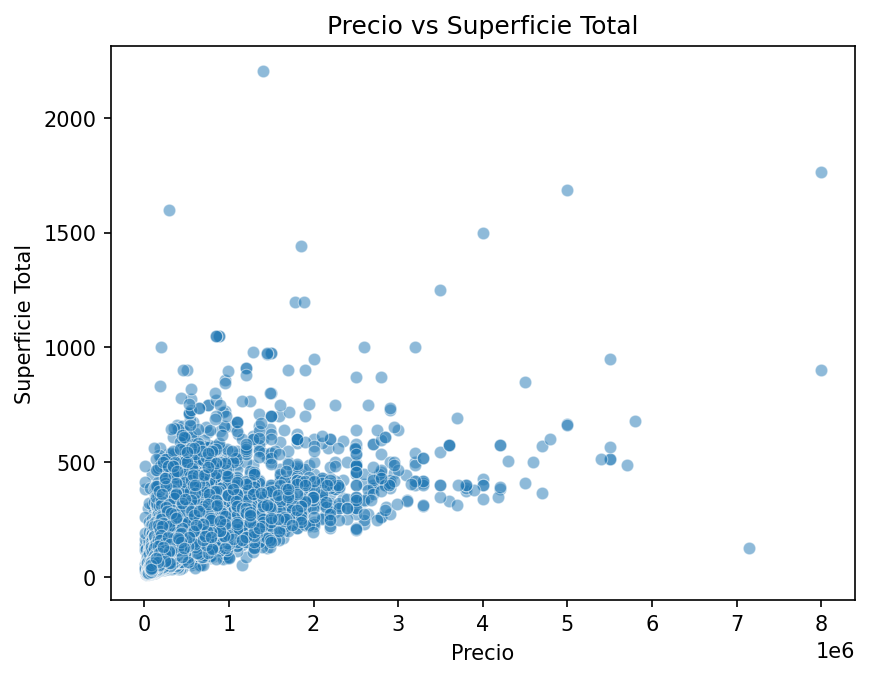

In [140]:
plt.figure(dpi=150)
grf = sns.scatterplot(data=df, x="precio", y="superficie_total", alpha=0.5)
grf = grf.set(
    title="Precio vs Superficie Total",
    xlabel="Precio",
    ylabel="Superficie Total",
)

Veamos la distribución del precio por metro cuadrado por tipo de propiedad

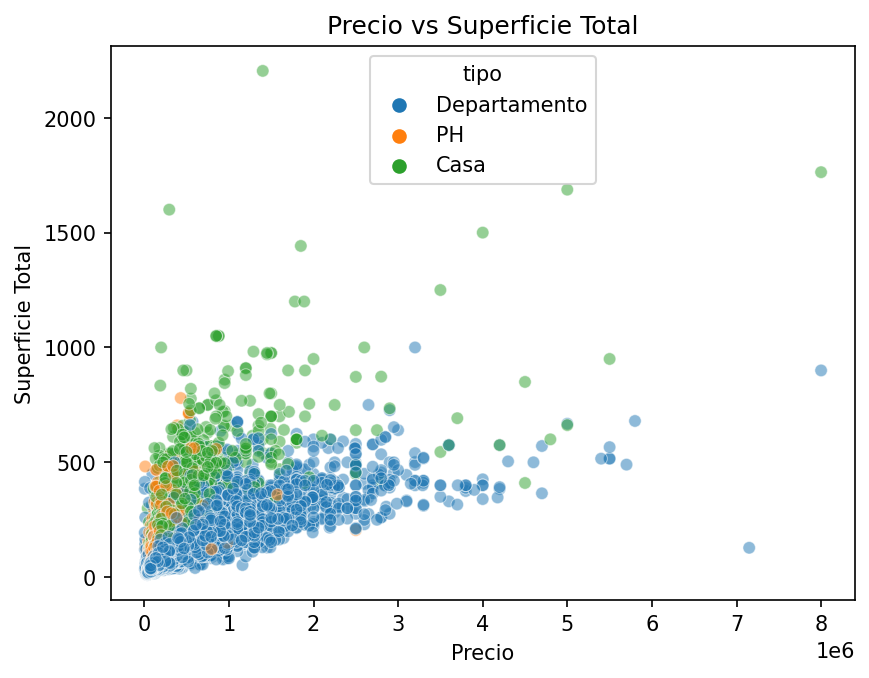

In [141]:
plt.figure(dpi=150)
grf = sns.scatterplot(data=df, x="precio", y="superficie_total", alpha=0.5, hue="tipo")
grf = grf.set(
    title="Precio vs Superficie Total",
    xlabel="Precio",
    ylabel="Superficie Total",
)

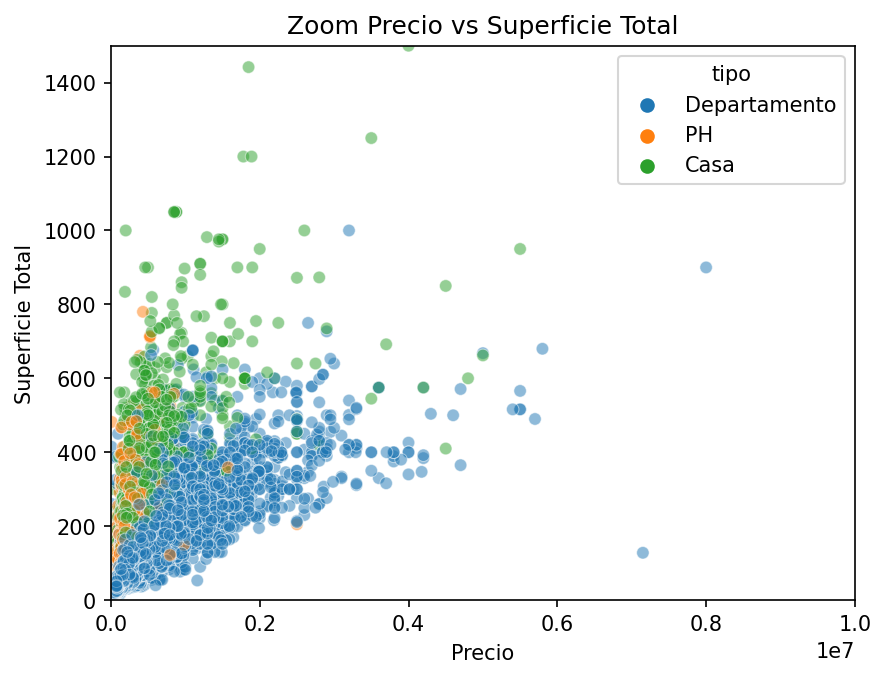

In [142]:
plt.figure(dpi=150)
grf = sns.scatterplot(data=df, x="precio", y="superficie_total", alpha=0.5, hue="tipo")
grf = grf.set(
    title="Zoom Precio vs Superficie Total",
    xlim=(0, 10000000),
    ylim=(0, 1500),
    xlabel="Precio",
    ylabel="Superficie Total",
)

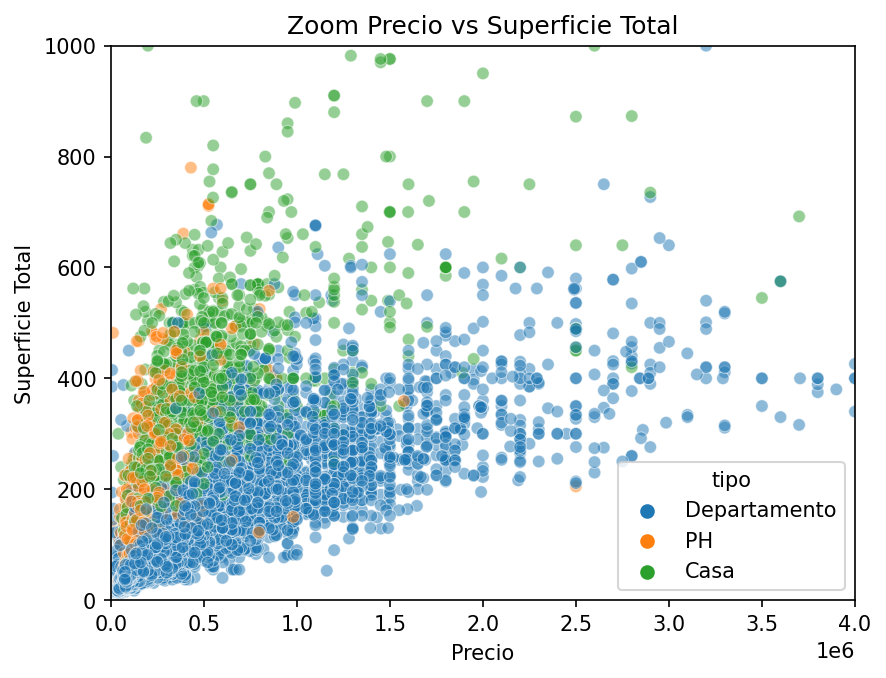

In [143]:
plt.figure(dpi=150)
grf = sns.scatterplot(data=df, x="precio", y="superficie_total", alpha=0.5, hue="tipo")
grf = grf.set(
    title="Zoom Precio vs Superficie Total",
    xlim=(0, 4000000),
    ylim=(0, 1000),
    xlabel="Precio",
    ylabel="Superficie Total",
)

#### Veamos los outliers multivariados:

Antes de hacer la particion de los datos, y como aclaramos previamente,aprovechamos que nos deshicimos de los NaNs en la mayoria de variables para hacer un analisis de outliers multivariados aplicando Mahalanobis:

##### Precio - Superficie

In [144]:
import scipy as sc
import numpy as np

X_base = df[["superficie_total", "precio"]]
sample_X = X_base.sample(frac=0.1)

mu = sample_X.mean()
X_diff = X_base - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T)
inv_cov = np.linalg.inv(cov)
W_base = sc.linalg.sqrtm(inv_cov)

Wx = np.matmul(W_base, X_diff)

mahal_dists = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])
df["mahal_pxs"] = mahal_dists

Nos encontramos con muchos outliers que quizas no habiamos podido ver en el analisis univariado, vamos a verlos en mas detalle:

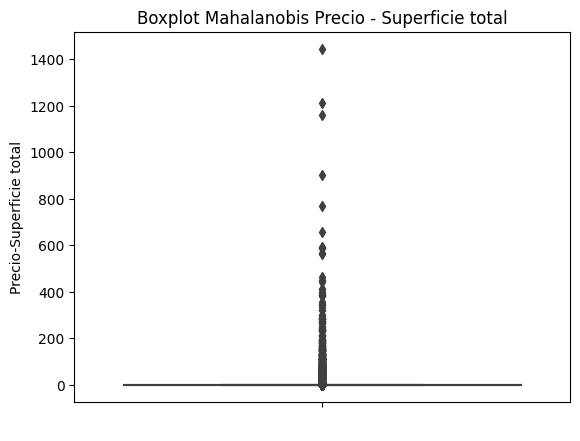

In [145]:
grf = sns.boxplot(y=df.mahal_pxs).set(
    title="Boxplot Mahalanobis Precio - Superficie total",
    xlabel=" ",
    ylabel="Precio-Superficie total",
)

Grafiquemos para tener una mejor idea de la distribucion de nuestros outliers:

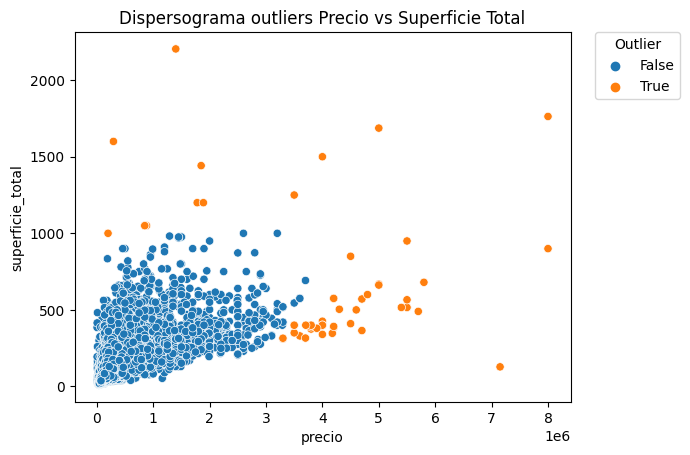

In [146]:
# Grafico scatter
es_outlier = df["mahal_pxs"] > 200

sns.scatterplot(x=df.precio, y=df.superficie_total, hue=es_outlier)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0, title="Outlier")
plt.title("Dispersograma outliers Precio vs Superficie Total")
plt.show()

Viendo el grafico podemos ver intuitivamente que con un valor de alrededor de 200 como umbral podemos encontrar los outliers mas interesantes para analizar con estas features:

In [147]:
df[df["mahal_pxs"] > 200]

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,titulo,dia,mes,geometry,mahal_pxs
1476,-34.590923,-58.384214,Recoleta,Departamento,9.0,4.0,668.0,668.0,5000000.0,"VENTA impresionante PISO muy ALTO 668,62 m2 co...",9,2,POINT (-58.38421 -34.59092),411.526093
2066,-34.612289,-58.359324,Puerto Madero,Departamento,6.0,4.0,426.0,426.0,4000000.0,VENTA importante PISO alto COMPLETO en torre E...,18,5,POINT (-58.35932 -34.61229),292.519047
3455,-34.612215,-58.360230,Puerto Madero,Departamento,8.0,4.0,365.0,346.0,4700000.0,Alvear Tower - Magnífico semipiso 5 estrellas....,10,6,POINT (-58.36023 -34.61222),463.942396
7850,-34.662911,-58.514027,Mataderos,Casa,8.0,6.0,1600.0,250.0,295000.0,Casa - Mataderos,19,7,POINT (-58.51403 -34.66291),769.134540
8804,-34.586413,-58.388982,Recoleta,Departamento,10.0,4.0,490.0,490.0,5700000.0,Posadas 1600,26,1,POINT (-58.38898 -34.58641),658.055016
11141,-34.565262,-58.478197,Coghlan,Casa,7.0,5.0,1050.0,650.0,880000.0,VENTA CASA 650M2 JARDIN PILETA 2 COCHERAS COGLHAN,30,12,POINT (-58.47820 -34.56526),237.084285
11206,-34.565262,-58.478197,Villa Urquiza,Casa,7.0,5.0,1050.0,650.0,880000.0,VENTA CASA 650M2 JARDIN PILETA 2 COCHERAS,30,12,POINT (-58.47820 -34.56526),237.084285
14048,-34.607357,-58.454595,Caballito,Casa,5.0,3.0,1000.0,229.0,199000.0,Venta casa Costa Esmeralda,10,1,POINT (-58.45459 -34.60736),288.006996
15570,-34.570078,-58.469164,Belgrano,Casa,10.0,7.0,1442.0,830.0,1850000.0,MAGNÍFICA RESIDENCIA - 10 AMB - GRAN PARQUE - ...,10,11,POINT (-58.46916 -34.57008),385.407573
16562,-34.587259,-58.389874,Recoleta,Departamento,6.0,5.0,384.0,370.0,4200000.0,"Espectacular y UNICO, Bioy Casares duplex, con...",5,2,POINT (-58.38987 -34.58726),346.193859


Primeramente podemos observar que los outliers cuando analizamos Precio - Superficie son en su gran mayoria propiedades de lujo, por ende a pesar de que aparecen como anomalas, las consideramos como valores correctos.

Por otro lado notamos dos casos que no cumplen con esto:

In [148]:
df.loc[[66372, 7850]]

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,titulo,dia,mes,geometry,mahal_pxs
66372,-34.606834,-58.396386,Balvanera,Casa,10.0,6.0,410.0,410.0,4500000.0,Venta en Block Propiedad en Lote Propio apto p...,16,3,POINT (-58.39639 -34.60683),398.621424
7850,-34.662911,-58.514027,Mataderos,Casa,8.0,6.0,1600.0,250.0,295000.0,Casa - Mataderos,19,7,POINT (-58.51403 -34.66291),769.134540


* La primera podemos ver por su titulo que es una propiedad en bloque, asi que la vamos a eliminar.
* La segunda es inusual porque se encuentra en otra zona, lo cual en principio podria explicar su precio bajo pero resalta como anomala la relacion entre superficie total y cubierta, asi como superficie total y ambientes. Nos hace sospechar que tiene datos incorrectos y por eso la eliminamos tambien.

In [149]:
# Borramos los outliers invalidos
idx = [66372, 7850]
df.drop(idx, inplace=True)

##### Ambientes - Superficie

In [150]:
X_base = df[["superficie_total", "ambientes"]]
sample_X = X_base.sample(frac=0.1)

mu = sample_X.mean()
X_diff = X_base - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T)
inv_cov = np.linalg.inv(cov)
W_base = sc.linalg.sqrtm(inv_cov)

Wx = np.matmul(W_base, X_diff)

mahal_dists = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])
df["mahal_axs"] = mahal_dists

Nuevamente descubrimos algunos outliers para analizar:

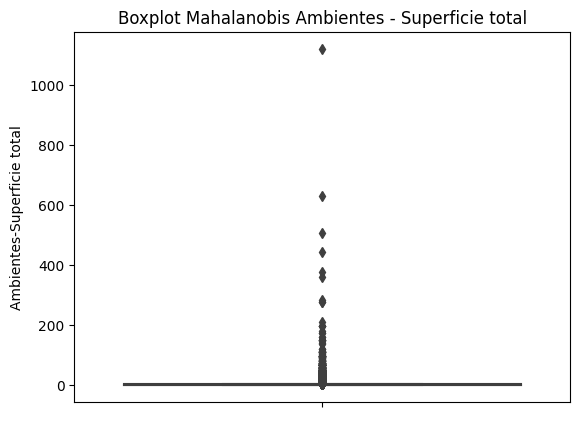

In [151]:
grf = sns.boxplot(y=df.mahal_axs).set(
    title="Boxplot Mahalanobis Ambientes - Superficie total",
    xlabel=" ",
    ylabel="Ambientes-Superficie total",
)

Otra vez graficamos para intentar encontrar un umbral interesante para determinar los outliers:

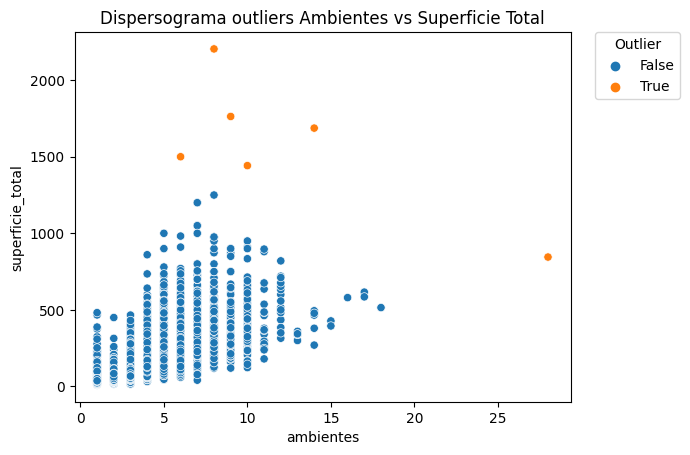

In [152]:
# Grafico scatter
es_outlier = df["mahal_axs"] > 300

sns.scatterplot(x=df.ambientes, y=df.superficie_total, hue=es_outlier)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0, title="Outlier")
plt.title("Dispersograma outliers Ambientes vs Superficie Total")
plt.show()

Luego de probar varios umbrales, 300 parece ser un buen valor para separar los valores anomalos. Ahora veamos las propiedades seleccionadas en mas detalle:

In [153]:
df[df["mahal_axs"] > 300]

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,titulo,dia,mes,geometry,mahal_pxs,mahal_axs
15570,-34.570078,-58.469164,Belgrano,Casa,10.0,7.0,1442.0,830.0,1850000.0,MAGNÍFICA RESIDENCIA - 10 AMB - GRAN PARQUE - ...,10,11,POINT (-58.46916 -34.57008),385.407573,360.730313
21575,-34.549877,-58.443350,Belgrano,Casa,6.0,5.0,1500.0,1000.0,4000000.0,Casa - Belgrano,9,6,POINT (-58.44335 -34.54988),336.294340,507.348252
28396,-34.565947,-58.442326,Belgrano,Casa,9.0,5.0,1763.0,1763.0,8000000.0,Casa Estilo Frances en Venta y/o Alquiler | V...,12,5,POINT (-58.44233 -34.56595),902.677917,630.687228
47791,-34.557749,-58.471384,Belgrano,Casa,8.0,8.0,2204.0,2204.0,1400000.0,CASA UNICA 45 METROS DE FRENTE COGHLAN # HISTO...,26,2,POINT (-58.47138 -34.55775),1213.750345,1121.358459
68131,-34.570959,-58.458106,Belgrano,Casa,28.0,16.0,845.0,845.0,950000.0,Imponente casa inglesa de 3 plantas S.S. en ...,5,5,POINT (-58.45811 -34.57096),131.182466,376.221240
71353,-34.572508,-58.464757,Belgrano,Casa,14.0,8.0,1687.0,942.0,5000000.0,DOS CASAS EN BLOQUE EN LOTE DE 25.98 X 65.94 ...,7,1,POINT (-58.46476 -34.57251),452.631458,445.071228


Nuevamente, con los datos que tenemos disponibles parecen ser todas propiedades grandes y de lujo, las cuales aparecen como anomalas por su precio elevado en comparacion al numero relativamente bajo de ambientes. La excepcion es la siguiente propiedad, la cual es excepcional por sus dimensiones y precio relativamente bajo:

In [154]:
df.loc[[68131]]

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,titulo,dia,mes,geometry,mahal_pxs,mahal_axs
68131,-34.570959,-58.458106,Belgrano,Casa,28.0,16.0,845.0,845.0,950000.0,Imponente casa inglesa de 3 plantas S.S. en ...,5,5,POINT (-58.45811 -34.57096),131.182466,376.22124


Igualmente podemos concluir que todas se encuentran dentro de valores razonables.

##### Superficie Total - Superficie Cubierta

In [155]:
X_base = df[["superficie_total", "superficie_cubierta"]]
sample_X = X_base.sample(frac=0.1)

mu = sample_X.mean()
X_diff = X_base - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T)
inv_cov = np.linalg.inv(cov)
W_base = sc.linalg.sqrtm(inv_cov)

Wx = np.matmul(W_base, X_diff)

mahal_dists = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])
df["mahal_sxs"] = mahal_dists

Otra vez podemos ver nuevos outliers que aparecen, analicemos como son:

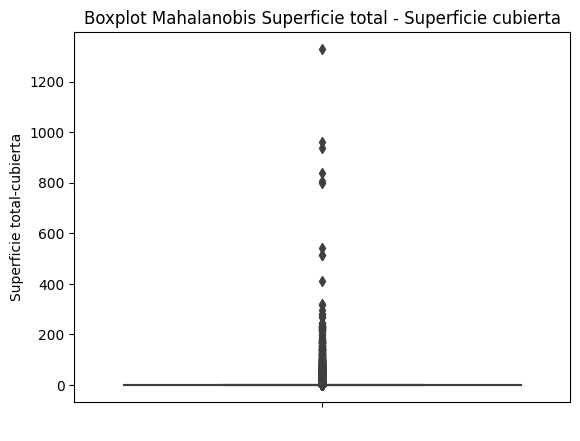

In [156]:
grf = sns.boxplot(y=df.mahal_sxs).set(
    title="Boxplot Mahalanobis Superficie total - Superficie cubierta",
    xlabel=" ",
    ylabel="Superficie total-cubierta",
)

Grafiquemos para entender mejor como se distribuyen y elegir un umbral adecuado:

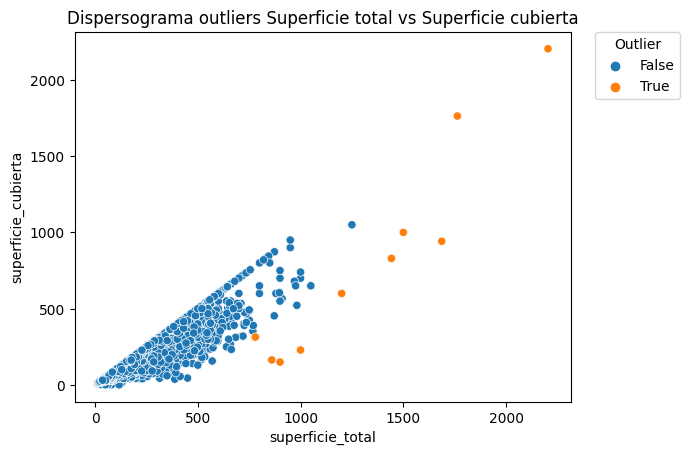

In [157]:
# Grafico scatter
es_outlier = df["mahal_sxs"] > 300

sns.scatterplot(x=df.superficie_total, y=df.superficie_cubierta, hue=es_outlier)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0, title="Outlier")
plt.title("Dispersograma outliers Superficie total vs Superficie cubierta")
plt.show()

Despues de probar varias alternativas, nos decidimos por 300 y seguimos analizando las propiedades una por una:

In [158]:
df[df["mahal_sxs"] > 300]

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,titulo,dia,mes,geometry,mahal_pxs,mahal_axs,mahal_sxs
3124,-34.631848,-58.505288,Versalles,Casa,5.0,4.0,777.0,313.0,550000.0,CASA 6 AMBS PISCINA JARDIN 4 COCHERAS VERSALLES,22,4,POINT (-58.50529 -34.63185),132.293007,111.109290,316.559401
14048,-34.607357,-58.454595,Caballito,Casa,5.0,3.0,1000.0,229.0,199000.0,Venta casa Costa Esmeralda,10,1,POINT (-58.45459 -34.60736),288.006996,208.665537,962.341238
15570,-34.570078,-58.469164,Belgrano,Casa,10.0,7.0,1442.0,830.0,1850000.0,MAGNÍFICA RESIDENCIA - 10 AMB - GRAN PARQUE - ...,10,11,POINT (-58.46916 -34.57008),385.407573,360.730313,542.685254
21575,-34.549877,-58.443350,Belgrano,Casa,6.0,5.0,1500.0,1000.0,4000000.0,Casa - Belgrano,9,6,POINT (-58.44335 -34.54988),336.294340,507.348252,409.876899
28396,-34.565947,-58.442326,Belgrano,Casa,9.0,5.0,1763.0,1763.0,8000000.0,Casa Estilo Frances en Venta y/o Alquiler | V...,12,5,POINT (-58.44233 -34.56595),902.677917,630.687228,837.856026
30797,-34.562704,-58.501379,Saavedra,Casa,4.0,3.0,860.0,164.0,950000.0,Casa - Saavedra,7,6,POINT (-58.50138 -34.56270),137.440242,161.177184,797.729888
42975,-34.634128,-58.406030,Parque Patricios,PH,5.0,4.0,780.0,314.0,430000.0,VTA PH 5 amb P.Patricios Pileta Quincho+2 Dep....,2,6,POINT (-58.40603 -34.63413),143.806588,112.215971,319.379610
45283,-34.596801,-58.383768,Recoleta,Departamento,8.0,2.0,900.0,150.0,8000000.0,Departamento - Recoleta,13,9,POINT (-58.38377 -34.59680),1160.415752,119.308533,936.738772
47791,-34.557749,-58.471384,Belgrano,Casa,8.0,8.0,2204.0,2204.0,1400000.0,CASA UNICA 45 METROS DE FRENTE COGHLAN # HISTO...,26,2,POINT (-58.47138 -34.55775),1213.750345,1121.358459,1329.082521
59250,-34.553399,-58.444800,Belgrano,Casa,7.0,6.0,1200.0,600.0,1780000.0,Casa - Belgrano,17,9,POINT (-58.44480 -34.55340),243.164167,275.866287,515.262383


Siguiendo la linea de los analisis anteriores vemos nuevamente un conjunto de casas de lujo de grandes dimensiones. En este caso tambien se encuentran dentro de los parametros razonables y los valores se explican por los grandes terrenos en los que estan emplazadas. Con la excepcion de las siguientes propiedades:

In [159]:
df.loc[[14048, 30797, 45283]]

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,titulo,dia,mes,geometry,mahal_pxs,mahal_axs,mahal_sxs
14048,-34.607357,-58.454595,Caballito,Casa,5.0,3.0,1000.0,229.0,199000.0,Venta casa Costa Esmeralda,10,1,POINT (-58.45459 -34.60736),288.006996,208.665537,962.341238
30797,-34.562704,-58.501379,Saavedra,Casa,4.0,3.0,860.0,164.0,950000.0,Casa - Saavedra,7,6,POINT (-58.50138 -34.56270),137.440242,161.177184,797.729888
45283,-34.596801,-58.383768,Recoleta,Departamento,8.0,2.0,900.0,150.0,8000000.0,Departamento - Recoleta,13,9,POINT (-58.38377 -34.59680),1160.415752,119.308533,936.738772


Estas resaltan por su gran diferencia entre las dos superficies, fuera de los valores que venimos observando con patios hasta 5 veces mas grandes que la edificacion, es particularmente ilogico el caso del Departamento para estos valores.

In [160]:
# Borramos los outliers invalidos
idx = [14048, 30797, 45283]
df.drop(idx, inplace=True)

El caso del Departamento con valores tan particulares invita a analizar valores anomalos que en principio no parecen tan extremos pero quizas si lo son por el tipo de propiedad:

In [161]:
# Busquemos un umbral mas bajo pero solamente para los departamentos
df[(df["mahal_sxs"] > 100) & (df["tipo"] == "Departamento")]

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,titulo,dia,mes,geometry,mahal_pxs,mahal_axs,mahal_sxs
872,-34.577484,-58.405751,Palermo,Departamento,5.0,3.0,535.0,220.0,2800000.0,VENTA con RENTA hasta Feb 2020 TORRES DE GELL...,20,9,POINT (-58.40575 -34.57748),104.067596,40.318882,143.217028
1476,-34.590923,-58.384214,Recoleta,Departamento,9.0,4.0,668.0,668.0,5000000.0,"VENTA impresionante PISO muy ALTO 668,62 m2 co...",9,2,POINT (-58.38421 -34.59092),411.526093,49.137462,106.133545
10100,NaN,NaN,Flores,Departamento,3.0,2.0,380.0,80.0,240000.0,Zuviría 2200 * Casa EN 1ER. PISO C/ COCHERA ...,16,5,POINT EMPTY,28.012377,24.740121,145.965905
10200,-34.596567,-58.400661,Barrio Norte,Departamento,2.0,1.0,450.0,45.0,96000.0,Departamento - Barrio Norte,5,12,POINT (-58.40066 -34.59657),51.553025,49.195001,280.806944
15661,-34.557023,-58.443115,Belgrano,Departamento,4.0,3.0,578.0,285.0,2700000.0,Departamento - Belgrano,10,11,POINT (-58.44311 -34.55702),93.014380,59.837878,118.386895
16929,-34.589909,-58.385575,Recoleta,Departamento,6.0,3.0,494.0,202.0,1100000.0,SEMIPISO con Cochera MEGA PATIO en Av. Alvear,26,3,POINT (-58.38558 -34.58991),27.587713,26.928034,122.839493
19078,-34.592027,-58.388292,Recoleta,Departamento,5.0,3.0,500.0,130.0,335000.0,"LUMINOSA, 3 DORM, COCHERA, BAULERA ,132 m RECO...",4,10,POINT (-58.38829 -34.59203),51.224030,33.102721,216.555381
19092,-34.592027,-58.388292,Barrio Norte,Departamento,5.0,3.0,500.0,130.0,335000.0,"LUMINOSA, 3 DORM, COCHERA, BAULERA ,132 m RECO...",4,10,POINT (-58.38829 -34.59203),51.224030,33.102721,216.555381
20431,-34.581389,-58.454805,Chacarita,Departamento,6.0,5.0,574.0,244.0,1350000.0,Departamento tipo casa de 5 dormit . 250 mts c...,10,9,POINT (-58.45480 -34.58139),39.249143,42.040237,156.269334
23536,-34.592027,-58.388292,Recoleta,Departamento,5.0,3.0,500.0,130.0,380000.0,"LUMINOSA, 3 DORM, COCHERA, BAULERA ,132 m RECO...",13,5,POINT (-58.38829 -34.59203),48.887452,33.102721,216.555381


Destacan las siguientes propiedades por la gran diferencia entre superficies, y mientras que otras podemos inferir que la justifican por patios, terrazas, cocheras, etc. en este caso nada apunta a algo que pueda explicar estos casos:

In [162]:
df.loc[[10200, 28858, 55784]]

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,titulo,dia,mes,geometry,mahal_pxs,mahal_axs,mahal_sxs
10200,-34.596567,-58.400661,Barrio Norte,Departamento,2.0,1.0,450.0,45.0,96000.0,Departamento - Barrio Norte,5,12,POINT (-58.40066 -34.59657),51.553025,49.195001,280.806944
28858,-34.637587,-58.510605,Villa Luro,Departamento,2.0,1.0,314.0,44.0,87000.0,DEPARTAMENTO 2 AMB A ESTRENAR VILLA LURO,24,3,POINT (-58.51060 -34.63759),22.093522,21.399229,122.635166
55784,-34.613676,-58.503965,Floresta,Departamento,1.0,1.0,388.0,38.0,67000.0,"Monoambiente divisible con recepción, apto pro...",1,9,POINT (-58.50397 -34.61368),37.890459,46.300346,209.973459


Como todo apunta a que son simplemente datos incorrectos y al ser solo 3, procedemos a borralos:

In [163]:
# Borramos los outliers invalidos
idx = [10200, 28858, 55784]
df.drop(idx, inplace=True)

Con esto concluimos el analisis de outliers y podemos borrar las columnas que utilizamos para el analisis con Mahalanobis:


In [164]:
df.drop(
    columns=[
        "mahal_pxs",
        "mahal_axs",
        "mahal_sxs",
    ],
    inplace=True,
)

#### Ademas vamos a eliminar el feature Titulo:
Si bien nos sirvio a la hora de decidir si algunos outliers eran razonables o no, gracias a que nos daba contexto adicional. A partir de ahora ya no nos aporta datos relevantes.

In [165]:
df.drop(
    columns=[
        "titulo",
    ],
    inplace=True,
)

<h4 align="center"><b> Dividimos el dataSet </b></h4>

#### Veamos que porcentaje del dataset eliminamos a lo largo del pre-procesamiento:

In [166]:
tam_final = df.shape[0]
print(
    f"Se eliminaron: {tam_inicial-tam_final} filas a lo largo de la totalidad del pre-procesamiento, lo cual representa un {round((tam_inicial-tam_final) / tam_inicial * 100, 3)}%"
)

Se eliminaron: 8156 filas a lo largo de la totalidad del pre-procesamiento, lo cual representa un 10.091%


In [167]:
df.reset_index(drop=True, inplace=True)

In [168]:
target = df["precio"] / df["superficie_total"]

In [169]:
x_train, x_test, y_train, y_test = train_test_split(
    df, target, test_size=0.2, random_state=0
)

In [170]:
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

#### <h4 align="center"><b> Determinar, de ser posible, estrategias para reparar los valores faltantes </b></h4>

##### Completamos las latitudes y longitudes con respecto a la media de su barrio.

In [171]:
valores_place = x_train.barrio.unique()

In [172]:
medias_latitud = {}
medias_latitud["default"] = x_train.latitud.mean()
medias_longitud = {}
medias_longitud["default"] = x_train.longitud.mean()
valores_place = x_train.groupby(by=["barrio"]).mean().index
grupos = x_train.groupby(by=["barrio"]).mean()

In [173]:
for place in valores_place:
    medias_latitud[place] = grupos.latitud[place]
    medias_longitud[place] = grupos.longitud[place]

In [174]:
for place in valores_place:
    mask = (x_train["longitud"].isnull()) & (x_train["barrio"] == place)
    x_train.loc[mask, "longitud"] = medias_longitud.get(
        place, medias_longitud["default"]
    )

In [175]:
for place in valores_place:
    mask = (x_train["latitud"].isnull()) & (x_train["barrio"] == place)
    x_train.loc[mask, "latitud"] = medias_latitud.get(place, medias_latitud["default"])

##### Completamos los datos faltantes de Dormitorios utilizando la moda segun la cantidad de ambientes, es decir, Imputacion Hot Deck

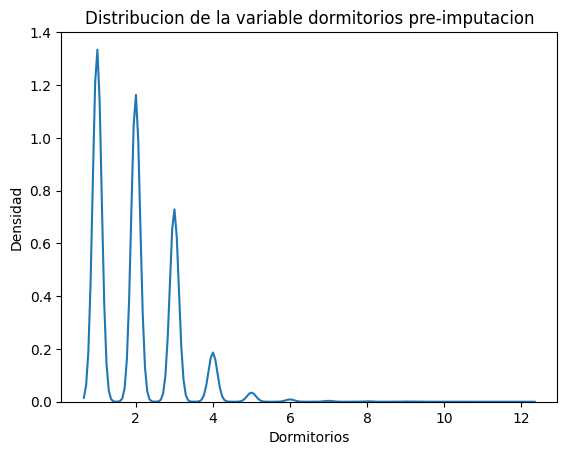

In [176]:
# Distribucion de la variable dormitorios antes de imputar o reparar datos
sns_hist = sns.kdeplot(data=x_train.dormitorios).set(
    title="Distribucion de la variable dormitorios pre-imputacion",
    xlabel="Dormitorios",
    ylabel="Densidad",
)

Vamos a calcular la moda para el feature dormitorios dependiendo de cuantos ambientes tenga la propiedad

In [177]:
moda_dormitorios = {}
# Necesito una moda por default por si la moda es nan en un ambiente dado
moda_dormitorios["default"] = x_train["ambientes"].mode()[0]
valores_ambientes = x_train.ambientes.unique().tolist()

Calculamos la moda para cada valor unico de ambientes:

In [178]:
for n in valores_ambientes:
    aux = x_train[(x_train.ambientes == n) & (x_train.dormitorios.notnull())]
    # Si la moda es nan no lo guardo en el diccionario
    if aux.shape[0] == 0:
        continue
    moda_dormitorios[n] = aux.dormitorios.mode()[0]

Luego completamos los nan de dormitorios con su respectiva moda segun la cantidad de ambientes:

In [179]:
x_train_na = x_train[x_train.dormitorios.isna()]
unique_rooms = x_train_na.ambientes.unique().tolist()

# Le asignamos el valor que corresponda a cada celda de dormitorio que este vacia
for n in unique_rooms:
    mask = ((x_train["dormitorios"].isnull())) & (x_train["ambientes"] == n)
    x_train.loc[mask, "dormitorios"] = moda_dormitorios.get(
        n, moda_dormitorios["default"]
    )

In [180]:
# Volvemos a chequear que no tengamos datos faltantes luego de imputar
x_train.dormitorios.isnull().sum()

0

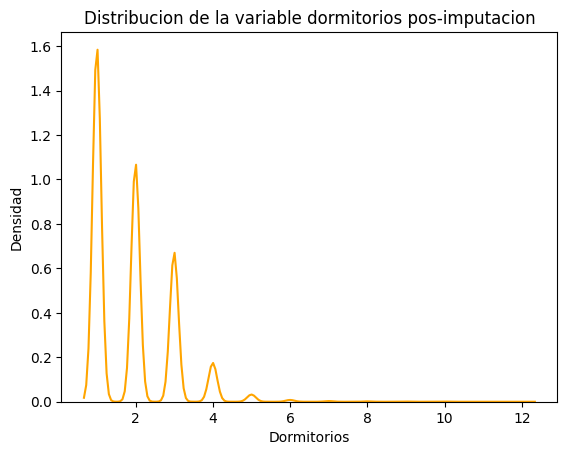

In [181]:
# Distribucion de la variable dormitorios despues de imputar o reparar datos
sns_hist = sns.kdeplot(data=x_train.dormitorios, color="orange").set(
    title="Distribucion de la variable dormitorios pos-imputacion",
    xlabel="Dormitorios",
    ylabel="Densidad",
)

Se observa que aumento la frecuencia del valor 1.

Vemos cuantas propiedades tienen mas dormitorios que ambientes luego de la imputacion, lo cual no tiene sentido:

In [182]:
x_train.apply(
    lambda row: True if row["ambientes"] < row["dormitorios"] else False, axis=1
).sum()

0

#### Agreguemos una feature nueva, la comuna a la que corresponde cada propiedad

In [183]:
import geopandas as geopd
import rtree
from geopandas.tools import sjoin

Vamos a utilizar un csv con los datos que necesitamos, se obtuvo de la pagina del gobierno de la ciudad:

In [184]:
# url='https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/comunas/comunas.csv'
# dp_comunas = geopd.read_file(url)
dp_comunas = geopd.read_file("./comunas.csv")
df_comunas = dp_comunas.copy()

In [185]:
# Tomamos solamente las columnas que necesitamos
df_comunas = df_comunas.filter(["COMUNAS", "geometry"])
df_comunas.rename(columns={"COMUNAS": "comuna"}, inplace=True)
# Casteamos las comunas a enteros para mayor comodidad
df_comunas["comuna"] = df_comunas.comuna.astype(float)
df_comunas["comuna"] = df_comunas.comuna.astype(int)

In [186]:
# Asignamos sus geometrias a las filas cuyas coordenadas estaban en NaN y ahora hemos imputado
new_geometry = geopd.points_from_xy(
    x_train[x_train.geometry.is_empty].longitud,
    x_train[x_train.geometry.is_empty].latitud,
)
x_train.loc[x_train.geometry.is_empty, "geometry"] = new_geometry

Unimos los dataframes asignando la comuna que le corresponde a cada punto segun su coordenada, es decir si un punto cae dentro de los limites de alguna de las comunas le asignamos el numero de la misma:

In [187]:
tam_inicial = x_train.shape[0]
df_comunas.set_crs("EPSG:4326", inplace=True)
x_train = x_train.sjoin(df_comunas, how="left")

In [188]:
# Borramos las filas que no caian dentro de los limites de la ciudad, pero sin borrar las que tenian sus coordenadas en NaN
x_train = x_train[~((x_train.index_right.isna()) & ~(x_train.geometry.is_empty))]
x_train.drop(columns="index_right", inplace=True)

Al hacer la asignacion de comunas segun coordenada, todas las propiedades que no se encuentren dentro de los limites son descartadas. Verifiquemos que el chequeo previo haya funcionado, no deberiamos perder ninguna fila.

In [189]:
tam_final = x_train.shape[0]
print(f"Se eliminaron: {tam_inicial-tam_final} filas al asignar comunas")

Se eliminaron: 0 filas al asignar comunas


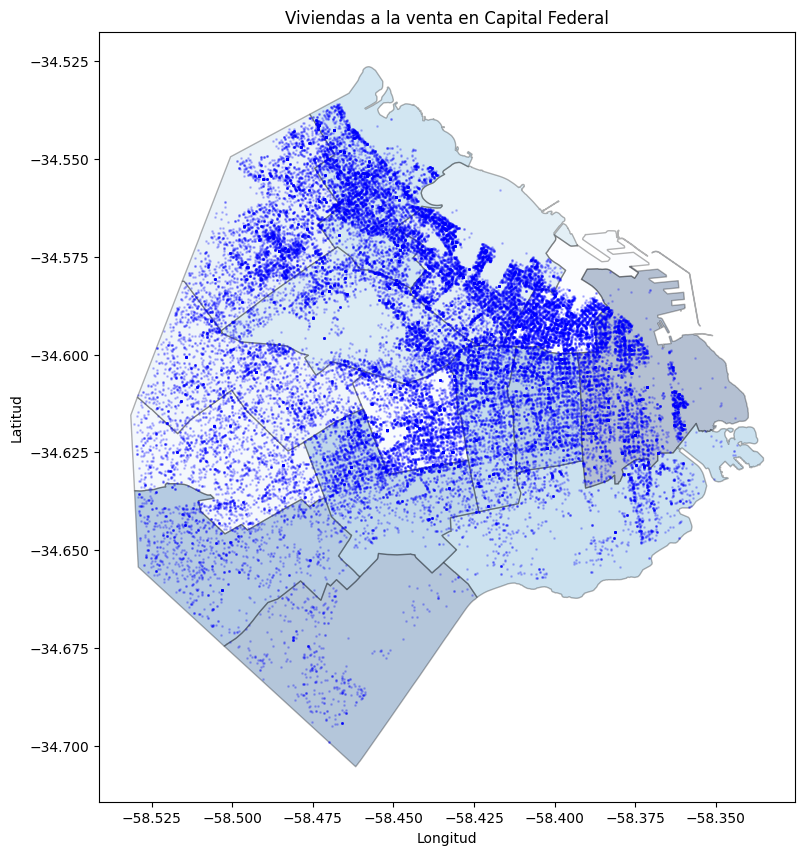

In [190]:
# Graficamos las viviendas en un mapa para visualizar su distribucion espacial
fig, ax = plt.subplots(figsize=(10, 10))
_ = df_comunas.plot(
    ax=ax, alpha=0.3, facecolor="Grey", edgecolor="k", linewidth=1, cmap="Blues"
).set(title="Viviendas a la venta en Capital Federal")
__ = x_train.plot(ax=ax, alpha=0.2, color="blue", markersize=1).set(
    xlabel="Longitud", ylabel="Latitud"
)

In [191]:
# Ya no necesitaremos el feature geometry
x_train.drop(
    columns=["geometry"],
    inplace=True,
)

In [192]:
x_train = x_train.sort_index()

#### Terminamos con el preprocesamiento

In [193]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58133 entries, 0 to 58132
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   latitud              58133 non-null  float64
 1   longitud             58133 non-null  float64
 2   barrio               58133 non-null  object 
 3   tipo                 58133 non-null  object 
 4   ambientes            58133 non-null  float64
 5   dormitorios          58133 non-null  float64
 6   superficie_total     58133 non-null  float64
 7   superficie_cubierta  58133 non-null  float64
 8   precio               58133 non-null  float64
 9   dia                  58133 non-null  int64  
 10  mes                  58133 non-null  int64  
 11  comuna               58133 non-null  int64  
dtypes: float64(7), int64(3), object(2)
memory usage: 5.8+ MB


Para reducir la dimensionalidad no necesitamos features de formato string

Justificacion del drop:
   * Barrio: Sera reemplazado por comuna
   * Dia: Irrelevante
   * Mes: Irrelevante
   * Precio: Porque tiene relacion con la target
   * Superficie_total: Porque tiene relacion con la target

In [194]:
feature_eliminar = ["barrio", "dia", "mes", "precio", "superficie_total"]

In [195]:
x_train.drop(columns=feature_eliminar, inplace=True)

#### OneHot

Seguidamente ejecutamos oneHot al feature tipo <br>
*Por que no ordinal?* Porque no se encuentra un orden relativo ni absoluto para decir porque PH debe ser 3 y Casa 1, por ejemplo.

In [196]:
ohe = OneHotEncoder(drop="first")
f_array = ohe.fit_transform(x_train[["tipo"]]).toarray()
f_name_tipo = np.array(ohe.categories_).ravel()[1:]  # Porque elimine el 1ero
feature_tipo = pd.DataFrame(f_array, columns=f_name_tipo)

In [197]:
x_train = pd.concat([x_train, feature_tipo], axis=1)

In [198]:
x_train.drop(columns=["tipo"], inplace=True)

#### Reflejamos lo mismo en el tests

In [199]:
x_test = preprocesamiento(
    x_test,
    feature_eliminar,
    medias_latitud,
    medias_longitud,
    moda_dormitorios,
    ohe,
    df_comunas,
)

#### Guardamos para continuar en la siguiente notebook

In [200]:
x_train.to_csv("./DataSet/x_train")

In [201]:
y_train.to_csv("./DataSet/y_train")

In [202]:
x_test.to_csv("./DataSet/x_test")

In [203]:
y_test.to_csv("./DataSet/y_test")

In [204]:
df_completo = preprocesamiento(
    df,
    ["dia", "mes", "barrio"],
    medias_latitud,
    medias_longitud,
    moda_dormitorios,
    ohe,
    df_comunas,
)
df_completo.to_csv("./DataSet/df_completo")

In [205]:
df_completo

,latitud,longitud,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,Departamento,PH,comuna
0,-34.637319,-58.361124,3.0,2.0,58.0,55.0,82900.0,1.0,0.0,4
1,-34.628647,-58.361871,4.0,3.0,70.0,70.0,99000.0,1.0,0.0,4
2,-34.623886,-58.412746,2.0,1.0,61.0,46.0,100000.0,0.0,1.0,5
3,-34.625588,-58.423056,4.0,2.0,104.0,54.0,185000.0,0.0,1.0,5
4,-34.629398,-58.425852,2.0,1.0,62.0,44.0,100000.0,1.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...
72662,-34.603245,-58.489810,4.0,3.0,130.0,100.0,220000.0,1.0,0.0,11
72663,-34.614063,-58.482814,3.0,2.0,68.0,60.0,161000.0,1.0,0.0,11
72664,-34.614175,-58.479062,1.0,1.0,51.0,30.0,75500.0,1.0,0.0,11
72665,-34.614175,-58.479062,1.0,1.0,37.0,31.0,74500.0,1.0,0.0,11
